In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from linearmodels import PanelOLS
from linearmodels import RandomEffects

# process PGIM effective rent data (no need to run it)

In [25]:
#PGIM data

df = pd.read_excel('Effective Rent By ZipCode - RealPage.xlsx')
df = (df.set_index(['Geography Name', 'Geography Type', 'Market Name', 'Unique ID',
           'Metric Type', 'Metric Name', 'Category', 'Niche']).stack().reset_index()
     .rename(columns={'level_8' : 'time_period', 0 : 'e_rent'})
    )

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
pgim_all = df[df['Market Name'].str.upper().str.contains('SAN FRAN').fillna(False)]
pgim_all = pgim_all[['Unique ID','time_period','e_rent']]
pgim_all = pgim_all.rename(columns = {'Unique ID': 'Zip Code','time_period':'y_dt'}).reset_index()

In [27]:
quarter_dict = {'Q1': '-01-01', 'Q2': '-04-01', 'Q3': '-07-01', 'Q4': '-10-01'}
pgim_all['y_dt'] = pgim_all['y_dt'].apply(lambda x: x[1:5] + quarter_dict[x[5:]])
pgim_all['y_dt'] = pd.to_datetime(pgim_all['y_dt'])

In [28]:
pgim_all = pgim_all.drop(columns = 'index')

In [29]:
pgim_all.to_csv('pgim_erent_all.csv',index=False)

# Start from here!

In [30]:
#### read data
pgim_all = pd.read_csv('pgim_erent_all.csv')
pgim_all['y_dt'] = pd.to_datetime(pgim_all['y_dt'])

In [31]:
# read cpi data
cpi = pd.read_csv('cpi.csv')
cpi.drop(columns=['Series ID','Period','Year'],inplace=True)
cpi['y_dt']= pd.to_datetime(cpi['Label'])
cpi.drop(columns=['Label'],inplace=True)
cpi.rename(columns={'Value':'CPI'},inplace=True)

In [32]:
cpi

,CPI,y_dt
0,169.300,2000-01-01
1,170.000,2000-02-01
2,171.000,2000-03-01
3,170.900,2000-04-01
4,171.200,2000-05-01
...,...,...
274,298.598,2022-11-01
275,298.990,2022-12-01
276,300.536,2023-01-01
277,301.648,2023-02-01


In [33]:
pgim_all = pd.merge(pgim_all,cpi, on = ['y_dt'], how = 'left')

In [34]:
base_quarter = '2000-10-01'

# Calculate CPI index for each quarter
pgim_all['cpi_index'] = pgim_all['CPI'] / pgim_all.loc[pgim_all['y_dt'] == base_quarter, 'CPI'].values[0]

# Calculate deflated rent price for each quarter
pgim_all['deflated e_rent'] = pgim_all['e_rent'] / pgim_all['cpi_index']

In [35]:
pgim_all

,Zip Code,y_dt,e_rent,CPI,cpi_index,deflated e_rent
0,94108.0,2001-01-01,1830.0,175.600,1.009776,1812.283599
1,94108.0,2001-04-01,1667.0,176.400,1.014376,1643.374717
2,94108.0,2001-07-01,1504.0,177.400,1.020127,1474.326945
3,94108.0,2001-10-01,1351.0,177.600,1.021277,1322.854167
4,94108.0,2002-01-01,1446.0,177.700,1.021852,1415.078222
...,...,...,...,...,...,...
3609,94925.0,2021-10-01,4188.0,276.522,1.590121,2633.762232
3610,94925.0,2022-01-01,4267.0,282.599,1.625066,2625.739298
3611,94925.0,2022-04-01,4417.0,288.611,1.659638,2661.424201
3612,94925.0,2022-07-01,4305.0,294.628,1.694238,2540.965217


In [36]:
pgim_all.to_csv('pgim_erent_all_deflated.csv',index=False)

In [37]:
#we only want data from 2011-2019, but for change we want to perserve values after 18 months for 2019
mask = (pgim_all['y_dt'].dt.year >= 2011) & (pgim_all['y_dt'].dt.year <= 2021)
df_filtered = pgim_all.loc[mask]

In [38]:
rent_df = df_filtered.reset_index(drop = True)

In [39]:

rent_df['y_dt'] = pd.to_datetime(rent_df['y_dt'])

# Get base year values for each zip code
base_year_rent = rent_df.loc[rent_df['y_dt'] == '2012-01-01', ['Zip Code', 'e_rent']].set_index('Zip Code')

# Create a dictionary for easier lookup
base_rent_dict = base_year_rent['e_rent'].to_dict()

# Apply base year values to each row
rent_df['base rent'] = rent_df['Zip Code'].map(base_rent_dict)

# Get future date values by shifting the data by 6 quarters (18 months)
rent_df['future date'] = rent_df.groupby('Zip Code')['y_dt'].shift(-6)
rent_df['future value'] = rent_df.groupby('Zip Code')['e_rent'].shift(-6)

# Calculate rent change
rent_df['rent_change'] = (rent_df['future value'] - rent_df['e_rent']) / rent_df['base rent']

# Filter the output to keep only the desired columns
output_columns = [
    'Zip Code', 'y_dt', 'e_rent', 'future date', 'future value', 'base rent', 'rent_change'
]
result = rent_df[output_columns]

# Display the result
result


,Zip Code,y_dt,e_rent,future date,future value,base rent,rent_change
0,94108.0,2011-01-01,1699.0,2012-07-01,2168.0,2001.0,0.234383
1,94108.0,2011-04-01,1714.0,2012-10-01,1948.0,2001.0,0.116942
2,94108.0,2011-07-01,1787.0,2013-01-01,2041.0,2001.0,0.126937
3,94108.0,2011-10-01,1864.0,2013-04-01,2166.0,2001.0,0.150925
4,94108.0,2012-01-01,2001.0,2013-07-01,2204.0,2001.0,0.101449
...,...,...,...,...,...,...,...
1886,94925.0,2020-10-01,3869.0,NaT,NaN,1838.0,NaN
1887,94925.0,2021-01-01,3988.0,NaT,NaN,1838.0,NaN
1888,94925.0,2021-04-01,4114.0,NaT,NaN,1838.0,NaN
1889,94925.0,2021-07-01,4063.0,NaT,NaN,1838.0,NaN


In [40]:
new_erent = result[['Zip Code','y_dt','rent_change']]

In [41]:
new_erent.to_csv('pgim_processed_change.csv')

# Population + Housing data from ACS

In [42]:
acs_all = pd.read_csv('pca_interpolated_ratechange_usa.csv')
acs_all['Zip Code'].nunique()

32950

In [43]:
acs_all[acs_all['Zip Code'] == 75201.0]

,Unnamed: 0,y_dt,Zip Code,Quarterly PC1,Quarterly PC2,Quarterly PC3,Quarterly PC4,Quarterly PC5,Quarterly PC6,Quarterly PC7,Quarterly PC8,Quarterly PC9,Quarterly PC10
21176,21176,2010-01-01,75201.0,0.519419,0.257630,-0.015399,-0.008595,-0.000990,0.000961,-0.001992,-0.001424,-0.002225,-0.000674
54126,54126,2010-04-01,75201.0,0.519419,0.257630,-0.015399,-0.008595,-0.000990,0.000961,-0.001992,-0.001424,-0.002225,-0.000674
87076,87076,2010-07-01,75201.0,0.519419,0.257630,-0.015399,-0.008595,-0.000990,0.000961,-0.001992,-0.001424,-0.002225,-0.000674
120026,120026,2010-10-01,75201.0,0.519419,0.257630,-0.015399,-0.008595,-0.000990,0.000961,-0.001992,-0.001424,-0.002225,-0.000674
152976,152976,2011-01-01,75201.0,0.519419,0.257630,-0.015399,-0.008595,-0.000990,0.000961,-0.001992,-0.001424,-0.002225,-0.000674
185926,185926,2011-04-01,75201.0,0.494435,0.257602,-0.015152,-0.003484,0.001724,0.000030,-0.002210,-0.001681,-0.002058,-0.000759
218876,218876,2011-07-01,75201.0,0.469451,0.257574,-0.014905,0.001628,0.004438,-0.000900,-0.002429,-0.001938,-0.001890,-0.000844
251826,251826,2011-10-01,75201.0,0.444466,0.257545,-0.014659,0.006740,0.007153,-0.001831,-0.002647,-0.002195,-0.001723,-0.000929
284776,284776,2012-01-01,75201.0,0.419482,0.257517,-0.014412,0.011852,0.009867,-0.002761,-0.002865,-0.002452,-0.001555,-0.001014
317726,317726,2012-04-01,75201.0,0.394443,0.257523,-0.012056,0.008198,0.006666,-0.001736,-0.002203,-0.001869,-0.001800,-0.000600


In [44]:

# # Convert 'y_dt' column to datetime
# acs_all['y_dt'] = pd.to_datetime(acs_all['y_dt'])

# # Calculate housing/person
# acs_all['Housing/person'] = acs_all['Quarterly Total Housing'] / acs_all['Quarterly Total Population']

# # Get base year values for each zip code
# base_year_values = acs_all.loc[acs_all['y_dt'] == '2012-01-01', ['Zip Code', 'Quarterly Total Population', 'Quarterly Total Housing']].set_index('Zip Code')

# # Create dictionaries for easier lookup
# base_population_dict = base_year_values['Quarterly Total Population'].to_dict()
# base_housing_dict = base_year_values['Quarterly Total Housing'].to_dict()

# # Apply base year values to each row
# acs_all['base Population'] = acs_all['Zip Code'].map(base_population_dict)
# acs_all['base Housing'] = acs_all['Zip Code'].map(base_housing_dict)

# # Get prior date values by shifting the data by 6 quarters (18 months)
# acs_all['prior date'] = acs_all.groupby('Zip Code')['y_dt'].shift(6)
# acs_all['prior population'] = acs_all.groupby('Zip Code')['Quarterly Total Population'].shift(6)
# acs_all['prior housing'] = acs_all.groupby('Zip Code')['Quarterly Total Housing'].shift(6)
# acs_all['prior housing/person'] = acs_all.groupby('Zip Code')['Housing/person'].shift(6)

# # Calculate changes
# acs_all['Population Change (%)'] = (acs_all['Quarterly Total Population'] - acs_all['prior population']) / acs_all['base Population']
# acs_all['Housing Change (%)'] = (acs_all['Quarterly Total Housing'] - acs_all['prior housing']) / acs_all['base Housing']
# acs_all['Housing/person Change (%)'] = (acs_all['Housing/person'] - acs_all['prior housing/person']) / acs_all['prior housing/person']

# # Filter the output to keep only the change columns, y_dt, and Zip Code
# output_columns = [
#     'y_dt', 'Zip Code', 'Population Change (%)', 'Housing Change (%)', 'Housing/person Change (%)'
# ]
# acs_processed = acs_all[output_columns]

# # Display the result
# acs_processed


In [45]:
# Convert 'y_dt' column to datetime
acs_all['y_dt'] = pd.to_datetime(acs_all['y_dt'])

# Get prior date values by shifting the data by 6 quarters (18 months)
acs_all_shifted = acs_all.groupby(['Zip Code']).shift(6).reset_index()
acs_all_shifted = pd.concat([acs_all[['Zip Code', 'y_dt']], acs_all_shifted], axis=1)

acs_all_shifted = acs_all_shifted.iloc[:, :2].join(acs_all_shifted.iloc[:, 5:])


In [46]:
# acs_all_shifted = acs_all.groupby(['Zip Code']).shift(6).reset_index()
# acs_all_shifted = pd.concat([acs_all[['Zip Code', 'y_dt']], acs_all_shifted], axis=1)
acs_processed = acs_all_shifted
acs_processed

,Zip Code,y_dt,Quarterly PC1,Quarterly PC2,Quarterly PC3,Quarterly PC4,Quarterly PC5,Quarterly PC6,Quarterly PC7,Quarterly PC8,Quarterly PC9,Quarterly PC10
0,88430.0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33971.0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33972.0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33973.0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33974.0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1581595,81612.0,2021-10-01,-0.180478,0.321228,0.000301,0.000383,-0.000448,-0.005976,-0.003049,0.000948,-0.015939,-0.006545
1581596,76957.0,2021-10-01,-0.405476,0.274096,0.000774,0.001332,-0.001195,-0.003200,0.000129,0.001796,0.004010,0.005157
1581597,97384.0,2021-10-01,-0.405684,0.479744,0.000700,0.001323,-0.001166,-0.004320,0.000528,0.000857,-0.003989,-0.002236
1581598,22035.0,2021-10-01,-0.479661,-0.278933,0.001502,0.001199,-0.001032,-0.011493,-0.001773,0.000042,-0.031911,-0.016282


In [47]:
# # Merge the original and shifted dataframe on Zip Code and y_dt columns
# acs_processed = pd.merge(acs_all[['Zip Code', 'y_dt', 'Quarterly PC1', 'Quarterly PC2', 'Quarterly PC3', 'Quarterly PC4', 'Quarterly PC5', 'Quarterly PC6', 'Quarterly PC7', 'Quarterly PC8', 'Quarterly PC9', 'Quarterly PC10']], acs_all_shifted, left_on=['Zip Code', 'y_dt'], right_on=['Zip Code', 'y_dt'])

# # Calculate changes
# for i in range(1, 11):
#     acs_processed[f'Quarterly PC{i} Change (%)'] = (acs_processed[f'Quarterly PC{i}'] - acs_processed[f'prior Quarterly PC{i}']) / acs_processed[f'prior Quarterly PC{i}']

# # Filter the output to keep only the change columns, y_dt, and Zip Code
# output_columns = [
#     'y_dt', 'Zip Code', 'Quarterly PC1 Change (%)', 'Quarterly PC2 Change (%)', 'Quarterly PC3 Change (%)', 'Quarterly PC4 Change (%)', 'Quarterly PC5 Change (%)', 'Quarterly PC6 Change (%)', 'Quarterly PC7 Change (%)', 'Quarterly PC8 Change (%)', 'Quarterly PC9 Change (%)', 'Quarterly PC10 Change (%)'
# ]


# acs_processed = acs_processed[output_columns]

# # Display the result
# acs_processed


In [48]:
acs_processed.isnull().sum()

Zip Code               0
y_dt                   0
Quarterly PC1     197700
Quarterly PC2     197700
Quarterly PC3     197700
Quarterly PC4     197700
Quarterly PC5     197700
Quarterly PC6     197700
Quarterly PC7     197700
Quarterly PC8     197700
Quarterly PC9     197700
Quarterly PC10    197700
dtype: int64

In [49]:
new_erent['Zip Code'].nunique()

49

In [50]:
acs_processed['Zip Code'].nunique()

32950

In [51]:
acs_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581600 entries, 0 to 1581599
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Zip Code        1581600 non-null  float64       
 1   y_dt            1581600 non-null  datetime64[ns]
 2   Quarterly PC1   1383900 non-null  float64       
 3   Quarterly PC2   1383900 non-null  float64       
 4   Quarterly PC3   1383900 non-null  float64       
 5   Quarterly PC4   1383900 non-null  float64       
 6   Quarterly PC5   1383900 non-null  float64       
 7   Quarterly PC6   1383900 non-null  float64       
 8   Quarterly PC7   1383900 non-null  float64       
 9   Quarterly PC8   1383900 non-null  float64       
 10  Quarterly PC9   1383900 non-null  float64       
 11  Quarterly PC10  1383900 non-null  float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 144.8 MB


# Merge_data

In [52]:
merge_data = pd.merge(acs_processed,new_erent, on = ['y_dt','Zip Code'], how = 'inner')
merge_data = merge_data.dropna()

In [53]:
merge_data

,Zip Code,y_dt,Quarterly PC1,Quarterly PC2,Quarterly PC3,Quarterly PC4,Quarterly PC5,Quarterly PC6,Quarterly PC7,Quarterly PC8,Quarterly PC9,Quarterly PC10,rent_change
81,94960.0,2011-07-01,0.519308,0.456460,-0.002913,-0.000686,-0.008252,-0.000528,-0.004399,-0.006899,0.000245,-0.000580,1.241291
82,94965.0,2011-07-01,0.519237,0.456452,-0.017129,-0.003578,-0.000641,-0.000130,-0.003654,-0.006578,0.000454,0.000055,0.143635
83,94947.0,2011-07-01,0.519306,0.456313,-0.008095,0.001995,-0.003737,-0.000558,-0.003743,-0.005983,0.000220,-0.000388,-0.008012
84,94901.0,2011-07-01,0.519200,0.455967,0.001374,-0.002938,-0.004120,0.000229,-0.005745,-0.007589,-0.000491,-0.000944,0.062616
85,94903.0,2011-07-01,0.519205,0.455862,-0.011654,-0.014216,-0.000224,0.002547,0.000503,0.002636,-0.001092,-0.000348,-0.002792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,94158.0,2020-04-01,-0.255854,0.447439,-0.001558,-0.000798,-0.000234,-0.001735,0.008504,-0.004389,0.004495,0.001776,-0.161410
1606,94401.0,2020-04-01,-0.255738,0.449895,-0.001951,-0.002067,-0.000573,-0.003328,-0.002827,0.000686,-0.001538,-0.001631,-0.148043
1607,94402.0,2020-04-01,-0.255710,0.449897,-0.002031,-0.002570,-0.000712,-0.004743,-0.001716,0.000122,-0.002035,-0.001680,-0.137432
1608,94403.0,2020-04-01,-0.255799,0.449918,-0.002297,-0.002297,-0.001088,-0.001317,-0.003522,0.000549,-0.002058,-0.002686,-0.057047


In [54]:
features= ['Quarterly PC1', 'Quarterly PC2']

In [55]:
X = merge_data[features]
y = merge_data['rent_change']

In [56]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent_change   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     277.6
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.59e-102
Time:                        17:08:58   Log-Likelihood:                 538.11
No. Observations:                1406   AIC:                            -1070.
Df Residuals:                    1403   BIC:                            -1054.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.3964      0.552     -4.341

In [57]:
merge_data.rename(columns={'y_dt':'year'},inplace=True)
year = pd.Categorical(merge_data.year)
merge_data = merge_data.set_index(['Zip Code', 'year'])
merge_data['year'] = year

In [58]:
exog_vars = features
exog = sm.add_constant(merge_data[exog_vars])
mod_ran= RandomEffects( merge_data['rent_change'], exog).fit()
print(mod_ran)

                        RandomEffects Estimation Summary                        
Dep. Variable:            rent_change   R-squared:                        0.2947
Estimator:              RandomEffects   R-squared (Between):              0.0400
No. Observations:                1406   R-squared (Within):               0.3048
Date:                Tue, May 09 2023   R-squared (Overall):              0.2828
Time:                        17:09:02   Log-likelihood                    578.91
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      293.04
Entities:                          40   P-value                           0.0000
Avg Obs:                       35.150   Distribution:                  F(2,1403)
Min Obs:                       7.0000                                           
Max Obs:                       36.000   F-statistic (robust):             291.13
                            

In [59]:
mod1= PanelOLS(merge_data['rent_change'], exog,entity_effects =False, time_effects = False).fit()
mod2= PanelOLS(merge_data['rent_change'], exog,entity_effects =False, time_effects = True).fit()
mod3= PanelOLS(merge_data['rent_change'], exog,entity_effects =True, time_effects = False).fit()
mod4= PanelOLS(merge_data['rent_change'], exog,entity_effects =True, time_effects = True).fit()

print(mod4)

                          PanelOLS Estimation Summary                           
Dep. Variable:            rent_change   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):             -38.304
No. Observations:                1406   R-squared (Within):              -4830.2
Date:                Tue, May 09 2023   R-squared (Overall):             -4416.1
Time:                        17:09:06   Log-likelihood                    797.66
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.6304
Entities:                          40   P-value                           0.5325
Avg Obs:                       35.150   Distribution:                  F(2,1329)
Min Obs:                       7.0000                                           
Max Obs:                       36.000   F-statistic (robust):             0.6304
                            

In [60]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import compare

In [61]:
print(compare({'Pooled OLS': mod1,'Random Effect': mod_ran, 'Fixed Effect 1': mod2, 'Fixed Effect 2': mod3, 'Fixed Effect 3': mod4}, stars = True))

                                             Model Comparison                                            
                             Pooled OLS     Random Effect  Fixed Effect 1  Fixed Effect 2  Fixed Effect 3
---------------------------------------------------------------------------------------------------------
Dep. Variable               rent_change       rent_change     rent_change     rent_change     rent_change
Estimator                      PanelOLS     RandomEffects        PanelOLS        PanelOLS        PanelOLS
No. Observations                   1406              1406            1406            1406            1406
Cov. Est.                    Unadjusted        Unadjusted      Unadjusted      Unadjusted      Unadjusted
R-squared                        0.2836            0.2947          0.0179          0.3051          0.0009
R-Squared (Within)               0.3048            0.3048         -2203.9          0.3051         -4830.2
R-Squared (Between)              0.0174       

In [62]:
##### do hausman test to compare re vs fe
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b -v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval


hausman_results = hausman(mod_ran, mod4) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: '+ str(hausman_results[2]))


chi-Squared: -1.1057300075390437
degrees of freedom: 3
p-Value: 1.0


# Machine Learning Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [35]:
# zip_codes = ['75052','75217','75228','75211','75243','75040','75043','75150','75227','75115','75149','75061','75007','75216','75080','75104','75062','75006','75060','75044','75154','75220','75019','75050','75063','75051','75042','75231','75206','75224','75081','75248','75038','75229','75232','75214','75041','75208','75238','75234','75204','75089','75181','75241','75088','75212','75254','75180','75082','75048','75230','75159','75205','75146','75240','75219','75218','75039','75225','75253','75116','75134','75237','75137','75235','75236','75249','75001','75233','75201','75203','75215','75209','75223','75244','75054','75210','75182','75125','75295','75346','75388','75207','75396','75141','75226','75369','75202','75336','75353','75172','75364','75386','75251','75247','75382','75045','75246','75363','75270','75339','75354','75239','75261','75398','75390','75037','75245','75258','75286','75310','75323','75387','75334','75340','75343','75344','75123','75138','75357','75380','75011','75015','75014','75017','75016','75030','75047','75046','75049','75053','75085','75083','75099','75106','75185','75187','75221','75222','75242','75250','75260','75263','75262','75265','75264','75267','75266','75275','75283','75277','75285','75284','75303','75313','75312','75320','75315','75326','75342','75356','75355','75358','75360','75359','75367','75372','75371','75374','75373','75378','75376','75381','75389','75391','75393','75392','75395','75394','75397','75059','75002','75035','75098','75071','75070','75080','75287','75033','75025','75074','75034','75023','75072','75093','75013','75024','75069','75075','75189','75078','75252','75082','75048','75009','75409','75407','75094','75442','75454','75173','75166','75424','75097','75026','75086','75121','75164','75301','75370','75379','75485','75067','75068','75056','75007','75287','75033','75034','75028','76227','76210','76262','76226','75077','75078','76092','75010','75036','76209','76208','75022','76201','76052','76177','76205','76266','76247','75057','76207','75065','76249','76258','76272','75008','76259','76299','75027','75029','76202','76204','76203','76206','75126','75159','75160','75142','75143','75182','75114','75161','75158','75147','75157','75118','75098','75087','75189','75032','75088','75132']


In [36]:
# zip_codes = list(map(float,zip_codes))

Preparing data

In [63]:
modelling_data = merge_data

In [64]:
modelling_data = modelling_data.drop(['Quarterly PC3','Quarterly PC4', 'Quarterly PC5', 'Quarterly PC6', 'Quarterly PC7', 'Quarterly PC8', 'Quarterly PC9', 'Quarterly PC10'], axis=1)


In [67]:
modelling_data.drop(['year'],axis=1,inplace=True)

In [68]:
modelling_data.reset_index(inplace=True)

In [72]:
modelling_data

,Zip Code,year,Quarterly PC1,Quarterly PC2,rent_change
0,94960.0,2011-07-01,0.519308,0.456460,1.241291
1,94965.0,2011-07-01,0.519237,0.456452,0.143635
2,94947.0,2011-07-01,0.519306,0.456313,-0.008012
3,94901.0,2011-07-01,0.519200,0.455967,0.062616
4,94903.0,2011-07-01,0.519205,0.455862,-0.002792
...,...,...,...,...,...
1401,94158.0,2020-04-01,-0.255854,0.447439,-0.161410
1402,94401.0,2020-04-01,-0.255738,0.449895,-0.148043
1403,94402.0,2020-04-01,-0.255710,0.449897,-0.137432
1404,94403.0,2020-04-01,-0.255799,0.449918,-0.057047


In [74]:
# Convert the 'year' column to datetime
modelling_data['year'] = pd.to_datetime(modelling_data['year'])

# Perform the train-test split
unique_zip_codes = modelling_data['Zip Code'].unique()
train_zip_codes, test_zip_codes = train_test_split(unique_zip_codes, test_size=0.2, random_state=42)

train_data = modelling_data[modelling_data['Zip Code'].isin(train_zip_codes)]
test_data = modelling_data[modelling_data['Zip Code'].isin(test_zip_codes)]

# Split the features and target variables
X_train = train_data[['Zip Code', 'year', 'Quarterly PC1', 'Quarterly PC2']]
y_train = train_data['rent_change']

X_test = test_data[['Zip Code', 'year', 'Quarterly PC1', 'Quarterly PC2']]
y_test = test_data['rent_change']


In [78]:
X_test

,Zip Code,year,Quarterly PC1,Quarterly PC2
4,94903.0,2011-07-01,0.519205,0.455862
12,94062.0,2011-07-01,0.519231,0.447412
15,94066.0,2011-07-01,0.519367,0.447469
16,94080.0,2011-07-01,0.519304,0.447621
19,94105.0,2011-07-01,0.519375,0.447824
...,...,...,...,...
1382,94080.0,2020-04-01,-0.255748,0.446662
1385,94105.0,2020-04-01,-0.255848,0.446925
1392,94010.0,2020-04-01,-0.255676,0.445929
1393,94014.0,2020-04-01,-0.255644,0.446010


Check if any Zip Codes in X_train match Zip Codes in X_test


In [96]:

# Get the unique zip codes in X_train and X_test
train_zip_codes = set(X_train['Zip Code'])
test_zip_codes = set(X_test['Zip Code'])

# Check if any zip code in X_train is also in X_test
common_zip_codes = train_zip_codes.intersection(test_zip_codes)

# Print the common zip codes
if common_zip_codes:
    print("Common zip codes found:")
    for zip_code in common_zip_codes:
        print(zip_code)
else:
    print("No common zip codes found.")


No common zip codes found.


In [76]:
# Find the correlations between features
corr_matrix = modelling_data.corr().abs()

# Find the indices of the upper triangle of the correlation matrix
upper_tri_indices = np.triu_indices_from(corr_matrix)

# Get the correlations of the upper triangle of the correlation matrix
upper_tri_corrs = corr_matrix.values[upper_tri_indices]

# Find the features that have a correlation greater than 0.9
high_corr_features = [modelling_data.columns[i] for i in range(len(modelling_data.columns))
                      if upper_tri_corrs[i] > 0.9]

# Print the highly correlated features
print("Highly correlated features:", high_corr_features)

# Remove the highly correlated features from the modelling data
modelling_data = modelling_data.drop(high_corr_features, axis=1)


Highly correlated features: ['const', 'Quarterly PC2']


In [283]:
# # Convert the year column to a datetime object
# modelling_data['year'] = pd.to_datetime(modelling_data['year'])

# # Define the cutoff date for the test set
# cutoff_date = pd.to_datetime('2020-04-01')

# # Split the data into training and test sets
# X_train = modelling_data[modelling_data['year'] < cutoff_date].drop('rent_change', axis=1)
# y_train = modelling_data[modelling_data['year'] < cutoff_date]['rent_change']
# X_test = modelling_data[modelling_data['year'] >= cutoff_date].drop('rent_change', axis=1)
# y_test = modelling_data[modelling_data['year'] >= cutoff_date][['rent_change','Zip Code']]

/var/folders/2_/1r7kvrgj32vcvy8llqd70dj00000gn/T/ipykernel_26104/4184324754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelling_data['year'] = pd.to_datetime(modelling_data['year'])


In [79]:
# Convert the year column to a datetime object
X_train['year'] = pd.to_datetime(X_train['year'])

# Create new columns for year and quarter
X_train['year_num'] = X_train['year'].dt.year
X_train['quarter_num'] = X_train['year'].dt.quarter

# Drop the original year column
X_train = X_train.drop('year', axis=1)

/var/folders/2_/1r7kvrgj32vcvy8llqd70dj00000gn/T/ipykernel_43338/2591200107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['year'] = pd.to_datetime(X_train['year'])


In [80]:
# Convert the year column to a datetime object
X_test['year'] = pd.to_datetime(X_test['year'])

# Create new columns for year and quarter
X_test['year_num'] = X_test['year'].dt.year
X_test['quarter_num'] = X_test['year'].dt.quarter

# Drop the original year column
X_test = X_test.drop('year', axis=1)

/var/folders/2_/1r7kvrgj32vcvy8llqd70dj00000gn/T/ipykernel_43338/2726228980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['year'] = pd.to_datetime(X_test['year'])


Starting with RF - Highly Tuned/Grid Searched

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


# Initialize the Random Forest Regressor with default hyperparameters
rf = RandomForestRegressor(max_depth=5,n_estimators=200, min_samples_leaf = 1, min_samples_split = 2)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict the e_rent change on the testing data
y_pred = rf.predict(X_test)

# Evaluate the model performance using R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: 0.5015272976418381


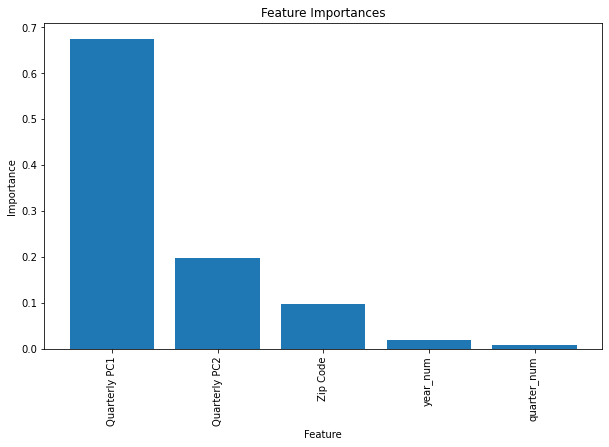

In [82]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create random forest model
rf = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Make predictions on the test data using the fitted model
y_pred = grid_search.predict(X_test)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

# Print R-squared value
print("R-squared value on test data:", r2)



# Deep Learning - LSTM

In [85]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [86]:
# Split the data into train and test sets

# Reshape the input data from (3932, 4) to (3932, 1, 4)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.1))
model.add(LSTM(units=128, return_sequences=False))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50))
# model.add(Dropout(0.1))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse')

# Train the model
model.fit(X_train_scaled, y_train, epochs=400, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance using R-squared
r2 = r2_score(y_test, y_pred)[:,0,0]
print("R-squared on test data:", r2)


Epoch 1/400


2023-05-09 17:15:50.097242: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - 2s 3ms/step - loss: 0.0404
Epoch 2/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0346
Epoch 3/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0312
Epoch 4/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 5/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0308
Epoch 6/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0308
Epoch 7/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0308
Epoch 8/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 9/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 10/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 11/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 12/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 13/400
35/35 [=============================

35/35 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 203/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 204/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 205/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 206/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 207/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 208/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 209/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 210/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 211/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 212/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 213/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 214/400
35/35 [=========

35/35 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 303/400
35/35 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 304/400
35/35 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 305/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 306/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 307/400
35/35 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 308/400
35/35 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 309/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 310/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 311/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 312/400
35/35 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 313/400
35/35 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 314/400
35/35 [=========

IndexError: invalid index to scalar variable.

In [87]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance using R-squared
# r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)


9/9 [==============================] - 0s 1ms/step
R-squared on test data: 0.5015272976418381


In [88]:
# Make predictions on the training set
y_pred_train = model.predict(X_train_scaled)

# Evaluate the model performance using R-squared on training data
r2_train = r2_score(y_train, y_pred_train)
print("R-squared on training data:", r2_train)

35/35 [==============================] - 0s 1ms/step
R-squared on training data: 0.38240868227520464


In [92]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with a standard scaler and an SVM regressor
svr = make_pipeline(StandardScaler(), SVR(C=1, kernel='rbf'))

# Train the model on the training data
svr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr.predict(X_test)

# Evaluate the model performance using r2 score
r2 = r2_score(y_test, y_pred)
print("SVM R2 score:", r2)


SVM R2 score: 0.5531030576375427


# All models at once approach - to see the overall fit and scores 

In [90]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [93]:
# Define the regression algorithms to test
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(kernel='linear'),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    XGBRegressor(objective='reg:squarederror', verbosity=0)
]

# Define the preprocessors to test
preprocessors = [
    StandardScaler(),
#     PolynomialFeatures(degree=2, include_bias=False)
]

# Initialize variables to keep track of the best pipeline and r2 score
best_pipeline = None
best_r2 = -np.inf

# Loop over the regression algorithms and preprocessors
for regressor in regressors:
    for preprocessor in preprocessors:
        # Create a pipeline with a preprocessor and a regression algorithm
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

        # Compute the cross-validation training R2 scores for the pipeline
        cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')
        cv_r2_mean = cv_r2_scores.mean()
        cv_r2_std = cv_r2_scores.std()

        # Train the model on the training data
        pipeline.fit(X_train, y_train)

        # Compute the training R2 score for the pipeline
        train_r2 = pipeline.score(X_train, y_train)

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test)

        # Evaluate the model performance using r2 score
        test_r2 = r2_score(y_test, y_pred)

        # Print the pipeline information and R2 scores
        print(type(regressor).__name__, type(preprocessor).__name__)
        print("Training R2 score: {:.4f}".format(train_r2))
        print("Cross-validation R2 scores: {:.4f} (+/- {:.4f})".format(cv_r2_mean, cv_r2_std))
        print("Testing R2 score: {:.4f}\n".format(test_r2))

        # Update the best pipeline and r2 score if a better one is found
        if test_r2 > best_r2:
            best_pipeline = pipeline
            best_r2 = test_r2

# Print the information about the best pipeline
print("Best pipeline:", best_pipeline)
print("Best R2 score:", best_r2)


LinearRegression StandardScaler
Training R2 score: 0.2644
Cross-validation R2 scores: -0.5411 (+/- 0.4980)
Testing R2 score: 0.4385

Ridge StandardScaler
Training R2 score: 0.2642
Cross-validation R2 scores: -0.3900 (+/- 0.4354)
Testing R2 score: 0.4384

Lasso StandardScaler
Training R2 score: 0.0000
Cross-validation R2 scores: -0.5479 (+/- 0.7150)
Testing R2 score: -0.0000

ElasticNet StandardScaler
Training R2 score: 0.0000
Cross-validation R2 scores: -0.5479 (+/- 0.7150)
Testing R2 score: -0.0000

SVR StandardScaler
Training R2 score: 0.2604
Cross-validation R2 scores: -0.3594 (+/- 0.3948)
Testing R2 score: 0.4338

KNeighborsRegressor StandardScaler
Training R2 score: 0.5272
Cross-validation R2 scores: -0.5194 (+/- 0.5033)
Testing R2 score: 0.3321

RandomForestRegressor StandardScaler
Training R2 score: 0.9443
Cross-validation R2 scores: -0.0576 (+/- 0.2600)
Testing R2 score: 0.2344

GradientBoostingRegressor StandardScaler
Training R2 score: 0.6993
Cross-validation R2 scores: -0.14

Grid Search LGBM, GradientBoosting, and CatBoost

In [382]:
# Define parameter grids for LGBM, GradientBoosting, and CatBoost
lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [5, 10, 15],
    'num_leaves': [31, 61]
}

gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7]
}

cat_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'depth': [5, 10, 15]
}

# Create LGBM, GradientBoosting, and CatBoost models
lgbm = LGBMRegressor(n_jobs=-1)
gb = GradientBoostingRegressor()
cat = CatBoostRegressor(verbose=False)

# Perform grid search to find best hyperparameters for each model
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=5, n_jobs=-1, scoring='r2')
gb_grid = GridSearchCV(gb, gb_params, cv=5, n_jobs=-1, scoring='r2')
cat_grid = GridSearchCV(cat, cat_params, cv=5, n_jobs=-1, scoring='r2')

# Fit the grid search objects to the data
lgbm_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
cat_grid.fit(X_train, y_train)

# Print best hyperparameters and R^2 score for each model
print('Best hyperparameters for LGBM:', lgbm_grid.best_params_)
print('Best R^2 score for LGBM:', lgbm_grid.best_score_)
print('Best hyperparameters for GradientBoosting:', gb_grid.best_params_)
print('Best R^2 score for GradientBoosting:', gb_grid.best_score_)
print('Best hyperparameters for CatBoost:', cat_grid.best_params_)
print('Best R^2 score for CatBoost:', cat_grid.best_score_)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Best hyperparameters for LGBM: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
Best R^2 score for LGBM: -0.10149118012226263
Best hyperparameters for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best R^2 score for GradientBoosting: -0.05611085288647592
Best hyperparameters for CatBoost: {'depth': 5, 'learning_rate': 0.05, 'n_estimators': 100}
Best R^2 score for CatBoost: -0.01972246962582429


# Fixing Overfitting 

In [95]:
# Define the regression algorithms to test
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=300, max_depth=5),
    GradientBoostingRegressor(n_estimators=100, max_depth=5),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, alpha=0.01, solver='adam'),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    XGBRegressor(n_estimators=300, max_depth=5,objective='reg:squarederror', verbosity=0)
]

# Define the preprocessors to test
preprocessors = [
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
]

# Initialize variables to keep track of the best pipeline and r2 score
best_pipeline = None
best_r2 = -np.inf

# Loop over the regression algorithms and preprocessors
for regressor in regressors:
    # Exclude SVR because it takes too long to train and often overfits
    if type(regressor).__name__ == 'SVR':
        continue
    for preprocessor in preprocessors:
        # Create a pipeline with a preprocessor and a regression algorithm
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

        # Compute the cross-validation training R2 scores for the pipeline
        cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
        cv_r2_mean = cv_r2_scores.mean()
        cv_r2_std = cv_r2_scores.std()

        # Train the model on the training data
        pipeline.fit(X_train, y_train)

        # Compute the training R2 score for the pipeline
        train_r2 = pipeline.score(X_train, y_train)

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test)

        # Evaluate the model performance using r2 score
        test_r2 = r2_score(y_test, y_pred)

        # Print the pipeline information and R2 scores
        print(type(regressor).__name__, type(preprocessor).__name__)
        print("Training R2 score: {:.4f}".format(train_r2))
        print("Cross-validation R2 scores: {:.4f} (+/- {:.4f})".format(cv_r2_mean, cv_r2_std))
        print("Testing R2 score: {:.4f}\n".format(test_r2))

        # Update the best pipeline and r2 score if a better one is found
        if test_r2 > best_r2:
            best_pipeline = pipeline
            best_r2 = test_r2

# Print the information about the best pipeline
print("Best pipeline:", best_pipeline)
print("Best R2 score:", best_r2)

LinearRegression StandardScaler
Training R2 score: 0.2644
Cross-validation R2 scores: -0.6512 (+/- 0.6129)
Testing R2 score: 0.4385

LinearRegression PolynomialFeatures
Training R2 score: 0.3112
Cross-validation R2 scores: -19686.6205 (+/- 39370.6618)
Testing R2 score: 0.4448

Ridge StandardScaler
Training R2 score: 0.2642
Cross-validation R2 scores: -0.5903 (+/- 0.5802)
Testing R2 score: 0.4384

Ridge PolynomialFeatures
Training R2 score: 0.3031
Cross-validation R2 scores: -14.4798 (+/- 27.1018)
Testing R2 score: 0.4525

Lasso StandardScaler
Training R2 score: 0.0000
Cross-validation R2 scores: -0.6170 (+/- 0.6527)
Testing R2 score: -0.0000



/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.03305e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.25801e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23443e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.2093e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/sunvid

Lasso PolynomialFeatures
Training R2 score: 0.2637
Cross-validation R2 scores: -0.5820 (+/- 0.5813)
Testing R2 score: 0.4382

ElasticNet StandardScaler
Training R2 score: 0.0000
Cross-validation R2 scores: -0.6170 (+/- 0.6527)
Testing R2 score: -0.0000



/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+01, tolerance: 3.617e-03
  model = cd_fast.enet_coordinate_descent(
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+01, tolerance: 3.295e-03
  model = cd_fast.enet_coordinate_descent(
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

ElasticNet PolynomialFeatures
Training R2 score: 0.2637
Cross-validation R2 scores: -0.5876 (+/- 0.5781)
Testing R2 score: 0.4385

KNeighborsRegressor StandardScaler
Training R2 score: 0.5272
Cross-validation R2 scores: -1.1678 (+/- 0.8923)
Testing R2 score: 0.3321

KNeighborsRegressor PolynomialFeatures
Training R2 score: 0.7293
Cross-validation R2 scores: -1.2046 (+/- 0.8066)
Testing R2 score: 0.2351

DecisionTreeRegressor StandardScaler
Training R2 score: 1.0000
Cross-validation R2 scores: -2.2216 (+/- 2.4375)
Testing R2 score: -0.6326

DecisionTreeRegressor PolynomialFeatures
Training R2 score: 1.0000
Cross-validation R2 scores: -2.2508 (+/- 2.1613)
Testing R2 score: -0.5734

RandomForestRegressor StandardScaler
Training R2 score: 0.5924
Cross-validation R2 scores: -0.5603 (+/- 0.4264)
Testing R2 score: 0.5108

RandomForestRegressor PolynomialFeatures
Training R2 score: 0.6139
Cross-validation R2 scores: -0.5373 (+/- 0.4531)
Testing R2 score: 0.5362

GradientBoostingRegressor Stand

XGBoost Grid Search

In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
}

# Create an XGBoost regressor
xgb = XGBRegressor()

# Create a grid search object
grid_search = GridSearchCV(xgb, param_grid=param_grid, scoring='r2', cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='rmse',
                early_stopping_rounds=10)

# Print the best hyperparameters and corresponding R-squared score
print("Best hyperparameters:", grid_search.best_params_)
print("Best R-squared score:", grid_search.best_score_)


# Time Series Models

In [272]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


# Group the training data by zip code
train_data = pd.concat([X_train, y_train], axis=1)
grouped_train_data = train_data.groupby('Zip Code')

# Fit an ARIMA model for each zip code and calculate evaluation metrics
models = {}
r2_scores = {}
mae_scores = {}
rmse_scores = {}
for zip_code, data in grouped_train_data:
    ts_train = data.set_index(pd.PeriodIndex(data['year'], freq='Q'))
    model = ARIMA(ts_train['rent_change'], order=(1,0,1))
    model_fit = model.fit()
    models[zip_code] = model_fit
    if zip_code in X_test['Zip Code'].unique():
        y_pred = model_fit.predict(start=len(ts_train), end=len(ts_train)+len(X_test[X_test['Zip Code'] == zip_code])-1)
        r2_scores[zip_code] = r2_score(y_test[X_test['Zip Code'] == zip_code], y_pred)
        mae_scores[zip_code] = mean_absolute_error(y_test[X_test['Zip Code'] == zip_code], y_pred)
        rmse_scores[zip_code] = np.sqrt(mean_squared_error(y_test[X_test['Zip Code'] == zip_code], y_pred))

if not r2_scores:
    print("No zip codes in X_test match the zip codes in X_train.")
else:
    # Print the top n zip codes with the highest R^2 scores
    n = 10  # Change this to print the top n zip codes
    sorted_r2_scores = sorted(r2_scores.items(), key=lambda item: item[1], reverse=True)
    for i, (zip_code, r2) in enumerate(sorted_r2_scores):
        if i >= n:
            break
        print(f"Zip code {zip_code}: R^2 score = {r2:.4f}, MAE = {mae_scores[zip_code]:.4f}, RMSE = {rmse_scores[zip_code]:.4f}")

    print(f"\nMean R^2 score: {np.mean([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Median R^2 score: {np.median([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Maximum R^2 score: {np.max([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Mean MAE: {np.mean(list(mae_scores.values())):.4f}")
    print(f"Median MAE: {np.median(list(mae_scores.values())):.4f}")
    print(f"Mean RMSE: {np.mean(list(rmse_scores.values())):.4f}")
    print(f"Median RMSE: {np.median(list(rmse_scores.values())):.4f}")


/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sun

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sun

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sun

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sun

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('N

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/U

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive param

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaco

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters f

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: Undefin

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: Undefin

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: Undefin

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/

Zip code 75001.0: R^2 score = nan, MAE = 0.0899, RMSE = 0.0899
Zip code 75002.0: R^2 score = nan, MAE = 0.0786, RMSE = 0.0786
Zip code 75006.0: R^2 score = nan, MAE = 0.0426, RMSE = 0.0426
Zip code 75007.0: R^2 score = nan, MAE = 0.0583, RMSE = 0.0583
Zip code 75010.0: R^2 score = nan, MAE = 0.1371, RMSE = 0.1371
Zip code 75013.0: R^2 score = nan, MAE = 0.1283, RMSE = 0.1283
Zip code 75019.0: R^2 score = nan, MAE = 0.1025, RMSE = 0.1025
Zip code 75023.0: R^2 score = nan, MAE = 0.0921, RMSE = 0.0921
Zip code 75024.0: R^2 score = nan, MAE = 0.1395, RMSE = 0.1395
Zip code 75025.0: R^2 score = nan, MAE = 0.2174, RMSE = 0.2174

Mean R^2 score: nan
Median R^2 score: nan
Maximum R^2 score: nan
Mean MAE: 0.0767
Median MAE: 0.0691
Mean RMSE: 0.0767
Median RMSE: 0.0691


/Users/sunvidaneja/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [327]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Group the training data by zip code
train_data = pd.concat([X_train, y_train], axis=1)
grouped_train_data = train_data.groupby('Zip Code')

# Fit a SARIMA model for each zip code and calculate R^2 score
models = {}
r2_scores = {}
mae_scores = {}
rmse_scores = {}
for zip_code, data in grouped_train_data:
    ts_train = data.set_index(pd.PeriodIndex(data['year'], freq='Q'))
    model = SARIMAX(ts_train['rent_change'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 4))
    model_fit = model.fit()
    models[zip_code] = model_fit
    if zip_code in X_test['Zip Code'].unique():
        y_pred = model_fit.predict(start=len(ts_train), end=len(ts_train)+len(X_test[X_test['Zip Code'] == zip_code])-1)
        r2_scores[zip_code] = r2_score(y_test[X_test['Zip Code'] == zip_code], y_pred)
        mae_scores[zip_code] = mean_absolute_error(y_test[X_test['Zip Code'] == zip_code], y_pred)
        rmse_scores[zip_code] = mean_squared_error(y_test[X_test['Zip Code'] == zip_code], y_pred, squared=False)

if not r2_scores:
    print("No zip codes in X_test match the zip codes in X_train.")
else:
    # Print the top n zip codes with the highest R^2 scores
    n = 10  # Change this to print the top n zip codes
    sorted_r2_scores = [(k, v) for k, v in sorted(r2_scores.items(), key=lambda item: item[1], reverse=True) if not np.isnan(v)]
    for i, (zip_code, r2) in enumerate(sorted_r2_scores):
        if i >= n:
            break
        print(f"Zip code {zip_code}: R^2 score = {r2:.4f}, MAE = {mae_scores[zip_code]:.4f}, RMSE = {rmse_scores[zip_code]:.4f}")

    mean_mae = np.mean([mae_scores[k] for k in mae_scores])
    median_mae = np.median([mae_scores[k] for k in mae_scores])
    mean_rmse = np.mean([rmse_scores[k] for k in rmse_scores])
    median_rmse = np.median([rmse_scores[k] for k in rmse_scores])
    print(f"\nMean R^2 score: {np.mean([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Median R^2 score: {np.median([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Maximum R^2 score: {np.max([r2 for _, r2 in sorted_r2_scores]):.4f}")
    print(f"Mean MAE: {np.mean(list(mae_scores.values())):.4f}")
    print(f"Median MAE: {np.median(list(mae_scores.values())):.4f}")
    print(f"Mean RMSE: {np.mean(list(rmse_scores.values())):.4f}")


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71559D+00    |proj g|=  1.34611D+01

At iterate    5    f= -1.75525D+00    |proj g|=  2.74004D-01

At iterate   10    f= -1.78965D+00    |proj g|=  3.14153D+00

At iterate   15    f= -1.79478D+00    |proj g|=  1.62153D-01

At iterate   20    f= -1.79520D+00    |proj g|=  1.06930D-01

At iterate   25    f= -1.79542D+00    |proj g|=  3.02581D-02

At iterate   30    f= -1.79542D+00    |proj g|=  9.92643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f= -2.01589D+00    |proj g|=  6.07041D+00

At iterate   15    f= -2.19237D+00    |proj g|=  3.33324D+00

At iterate   20    f= -2.22598D+00    |proj g|=  1.76327D-01

At iterate   25    f= -2.22600D+00    |proj g|=  1.05757D-02

At iterate   30    f= -2.22613D+00    |proj g|=  7.89005D-01

At iterate   35    f= -2.22824D+00    |proj g|=  8.37318D-01

At iterate   40    f= -2.22888D+00    |proj g|=  1.33343D-01

At iterate   45    f= -2.23037D+00    |proj g|=  1.16137D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     88      1     0     0   1.741D-01  -2.231D+00
  F =  -2.23072022677

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32040D+00    |proj g|=  7.20661D+00

At iterate    5    f= -2.32881D+00    |proj g|=  3.94338D-01

At iterate   10    f= -2.33022D+00    |proj g|=  2.34393D-01

At iterate   15    f= -2.33111D+00    |proj g|=  1.80491D+00

At iterate   20    f= -2.33360D+00    |proj g|=  7.06978D-02

At iterate   25    f= -2.33376D+00    |proj g|=  1.34625D-01

At iterate   30    f= -2.33384D+00    |proj g|=  1.87028D-02

At iterate   35    f= -2.33385D+00    |proj g|=  3.28377D-02

At iterate   40    f= -2.33385D+00    |proj g|=  1.08650D-02

At iterate   45    f= -2.33386D+00    |proj g|=  4.19856D-02

At iterate   50    f= -2.33386D+00    |proj g|=  4.28920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.48030D+00    |proj g|=  3.05747D+00

At iterate   45    f= -2.48737D+00    |proj g|=  9.62548D-02

At iterate   50    f= -2.48857D+00    |proj g|=  8.47448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   8.474D-03  -2.489D+00
  F =  -2.4885710359328210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.36974D+00    |proj g|=  4.22880D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   40    f= -2.29754D+00    |proj g|=  2.81253D-02

At iterate   45    f= -2.29755D+00    |proj g|=  6.51926D-02

At iterate   50    f= -2.29755D+00    |proj g|=  3.70082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     93      2     0     0   3.701D-03  -2.298D+00
  F =  -2.2975516573132193     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49937D+00    |proj g|=  1.65155D+01

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -9.16890D-01    |proj g|=  3.16651D-01

At iterate   40    f= -9.20410D-01    |proj g|=  1.37868D-02

At iterate   45    f= -9.20953D-01    |proj g|=  8.41835D-03

At iterate   50    f= -9.20971D-01    |proj g|=  9.06928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   9.069D-03  -9.210D-01
  F = -0.92097137044141919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -2.01176D+00    |proj g|=  1.76789D-01

At iterate   45    f= -2.02416D+00    |proj g|=  7.15996D-01

At iterate   50    f= -2.02961D+00    |proj g|=  4.77456D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   4.775D-02  -2.030D+00
  F =  -2.0296060283799990     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42268D-01    |proj g|=  4.20355D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.22971D+00    |proj g|=  3.81689D+00

At iterate   35    f= -2.23343D+00    |proj g|=  4.64997D-02

At iterate   40    f= -2.24825D+00    |proj g|=  3.32147D+00

At iterate   45    f= -2.32859D+00    |proj g|=  3.68566D+00

At iterate   50    f= -2.39337D+00    |proj g|=  1.31810D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   1.318D+00  -2.393D+00
  F =  -2.3933743800018976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.12661D+00    |proj g|=  1.38596D-01

At iterate   50    f= -2.12687D+00    |proj g|=  3.08604D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   3.086D-01  -2.127D+00
  F =  -2.1268670013982045     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52726D+00    |proj g|=  9.21205D-02

At iterate    5    f= -1.53008D+00    |proj g|=  1.54315D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11659D+00    |proj g|=  2.32745D+00

At iterate    5    f= -2.13435D+00    |proj g|=  2.55149D+00

At iterate   10    f= -2.13667D+00    |proj g|=  1.98748D+00

At iterate   15    f= -2.15013D+00    |proj g|=  6.99747D-01

At iterate   20    f= -2.15209D+00    |proj g|=  1.27067D+00

At iterate   25    f= -2.17457D+00    |proj g|=  5.38920D-01

At iterate   30    f= -2.19263D+00    |proj g|=  8.44326D-01

At iterate   35    f= -2.19685D+00    |proj g|=  2.26158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.00838D+00    |proj g|=  2.52731D+02

At iterate    5    f= -1.63869D+00    |proj g|=  1.78273D+01

At iterate   10    f= -1.91135D+00    |proj g|=  2.93861D-01

At iterate   15    f= -2.05314D+00    |proj g|=  2.00623D+00

At iterate   20    f= -2.09909D+00    |proj g|=  5.43050D+00

At iterate   25    f= -2.12356D+00    |proj g|=  1.69850D-01

At iterate   30    f= -2.12405D+00    |proj g|=  8.80676D-01

At iterate   35    f= -2.13254D+00    |proj g|=  1.78463D-01

At iterate   40    f= -2.13334D+00    |proj g|=  5.89892D-02

At iterate   45    f= -2.13397D+00    |proj g|=  4.83272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.96243D+00    |proj g|=  1.68824D+01

At iterate   10    f= -2.10873D+00    |proj g|=  8.36385D-01

At iterate   15    f= -2.12111D+00    |proj g|=  6.20816D-01

At iterate   20    f= -2.12288D+00    |proj g|=  1.54991D-01

At iterate   25    f= -2.17472D+00    |proj g|=  2.52232D+00

At iterate   30    f= -2.19800D+00    |proj g|=  2.39207D+00

At iterate   35    f= -2.32687D+00    |proj g|=  3.90000D-01

At iterate   40    f= -2.36658D+00    |proj g|=  1.28529D+00

At iterate   45    f= -2.37051D+00    |proj g|=  3.31999D-01

At iterate   50    f= -2.37174D+00    |proj g|=  1.07362D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -2.11306D+00    |proj g|=  1.61122D-01

At iterate   45    f= -2.11390D+00    |proj g|=  1.76913D-02

At iterate   50    f= -2.11397D+00    |proj g|=  1.58518D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   1.585D-02  -2.114D+00
  F =  -2.1139680045541005     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15335D+00    |proj g|=  6.27426D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02538D+00    |proj g|=  5.25060D+00

At iterate    5    f= -2.03085D+00    |proj g|=  9.68929D-01

At iterate   10    f= -2.04844D+00    |proj g|=  2.56523D+00

At iterate   15    f= -2.04978D+00    |proj g|=  1.65297D-02

At iterate   20    f= -2.04986D+00    |proj g|=  1.35349D-02

At iterate   25    f= -2.05082D+00    |proj g|=  5.86103D-01

At iterate   30    f= -2.05131D+00    |proj g|=  5.69913D-02

At iterate   35    f= -2.05477D+00    |proj g|=  7.38759D-02

At iterate   40    f= -2.06343D+00    |proj g|=  1.29693D-01

At iterate   45    f= -2.06390D+00    |proj g|=  4.06770D-02

At iterate   50    f= -2.06390D+00    |proj g|=  4.96156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.73575D+00    |proj g|=  1.99567D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.996D-02  -1.736D+00
  F =  -1.7357521815955488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28706D+00    |proj g|=  1.63213D+00

At iterate    5    f= -2.28978D+00    |proj g|=  1.69956D+00

At iterate   10    f= -2.29029D+00    |proj g|=  2.88917D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.67203D-01    |proj g|=  8.80865D-02

At iterate   10    f= -7.69948D-01    |proj g|=  5.93057D-02

At iterate   15    f= -7.76592D-01    |proj g|=  1.28862D+00

At iterate   20    f= -7.84816D-01    |proj g|=  1.85201D-01

At iterate   25    f= -7.92135D-01    |proj g|=  2.34455D-01

At iterate   30    f= -8.08233D-01    |proj g|=  3.58360D-01

At iterate   35    f= -8.15199D-01    |proj g|=  3.81250D-01

At iterate   40    f= -8.24758D-01    |proj g|=  5.15626D-01

At iterate   45    f= -8.27864D-01    |proj g|=  1.96523D-01

At iterate   50    f= -8.28730D-01    |proj g|=  2.04921D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.26455D+00    |proj g|=  7.16478D-02

At iterate   10    f= -1.26499D+00    |proj g|=  1.03027D-02

At iterate   15    f= -1.26500D+00    |proj g|=  1.35106D-03

At iterate   20    f= -1.26709D+00    |proj g|=  5.85688D-01

At iterate   25    f= -1.30783D+00    |proj g|=  3.73379D+00

At iterate   30    f= -1.33398D+00    |proj g|=  1.00693D-01

At iterate   35    f= -1.34252D+00    |proj g|=  5.42451D-02

At iterate   40    f= -1.34490D+00    |proj g|=  2.88233D-02

At iterate   45    f= -1.34492D+00    |proj g|=  2.76997D-03

At iterate   50    f= -1.34614D+00    |proj g|=  1.98814D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -7.19742D-01    |proj g|=  3.60576D-02

At iterate   50    f= -7.23157D-01    |proj g|=  9.08940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   9.089D-02  -7.232D-01
  F = -0.72315702489121891     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99518D+00    |proj g|=  3.49715D+00

At iterate    5    f= -2.00150D+00    |proj g|=  3.27744D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.57437D+00    |proj g|=  6.63578D-01

At iterate   30    f= -2.57643D+00    |proj g|=  3.45593D-01

At iterate   35    f= -2.57656D+00    |proj g|=  3.05052D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     64      1     0     0   4.243D-03  -2.577D+00
  F =  -2.5765627024844679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46963D+00    |proj g|=  2.85735D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.57794D+00    |proj g|=  5.51524D+00

At iterate   10    f= -2.11586D+00    |proj g|=  5.51488D+00

At iterate   15    f= -2.12857D+00    |proj g|=  2.32400D+00

At iterate   20    f= -2.28122D+00    |proj g|=  1.10499D+01

At iterate   25    f= -2.32008D+00    |proj g|=  1.67737D-01

At iterate   30    f= -2.36690D+00    |proj g|=  5.75564D+00

At iterate   35    f= -2.38510D+00    |proj g|=  2.32785D-01

At iterate   40    f= -2.38516D+00    |proj g|=  3.41052D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41    121      3     0     0   3.411D-03  -2.385D+00
  F =  -2.38516242717

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-5.306E+00  -gs= 8.864E-01 BFGS update SKIPPED

At iterate    5    f= -1.43808D+00    |proj g|=  3.50561D+00

At iterate   10    f= -2.44736D+00    |proj g|=  4.25333D+00

At iterate   15    f= -2.52339D+00    |proj g|=  5.00725D+00

At iterate   20    f= -2.60648D+00    |proj g|=  4.66829D-01

At iterate   25    f= -2.62790D+00    |proj g|=  5.69724D+00

At iterate   30    f= -2.68406D+00    |proj g|=  3.72047D-01

At iterate   35    f= -2.68705D+00    |proj g|=  7.88603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     76      1     1     0   2.026D-02  -2.687D+00
  F =  -2.6870991412184897     

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.04214D+00    |proj g|=  1.87054D-01

At iterate   25    f= -2.04505D+00    |proj g|=  2.48259D+00

At iterate   30    f= -2.09511D+00    |proj g|=  1.01365D+00

At iterate   35    f= -2.10386D+00    |proj g|=  4.69343D-01
  ys=-1.309E-06  -gs= 1.634E-06 BFGS update SKIPPED

At iterate   40    f= -2.10393D+00    |proj g|=  2.24461D-02

At iterate   45    f= -2.10399D+00    |proj g|=  1.21239D-01

At iterate   50    f= -2.10487D+00    |proj g|=  8.45472D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     1     0   8.455D-02  -2.105D+00
  F =  -2.1048739561960672     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78456D+00    |proj g|=  1.95070D+00

At iterate    5    f= -1.79211D+00    |proj g|=  2.81528D+00

At iterate   10    f= -1.79890D+00    |proj g|=  3.04307D-02

At iterate   15    f= -1.79920D+00    |proj g|=  4.40951D-01

At iterate   20    f= -1.79968D+00    |proj g|=  2.50139D-01

At iterate   25    f= -1.80478D+00    |proj g|=  3.26518D+00

At iterate   30    f= -1.81713D+00    |proj g|=  5.68190D-01

At iterate   35    f= -1.81863D+00    |proj g|=  9.10482D-02

At iterate   40    f= -1.82154D+00    |proj g|=  1.15203D+00

At iterate   45    f= -1.83119D+00    |proj g|=  4.41744D-01

At iterate   50    f= -1.83434D+00    |proj g|=  1.01516D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -7.96271D-01    |proj g|=  1.22576D+00

At iterate   20    f= -8.23776D-01    |proj g|=  3.18011D-01

At iterate   25    f= -8.24216D-01    |proj g|=  1.84372D-02

At iterate   30    f= -8.24243D-01    |proj g|=  1.08580D-02

At iterate   35    f= -8.24262D-01    |proj g|=  4.15062D-03

At iterate   40    f= -8.24277D-01    |proj g|=  3.87912D-04

At iterate   45    f= -8.24277D-01    |proj g|=  1.20449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     68      1     0     0   1.204D-04  -8.243D-01
  F = -0.82427692592476132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -3.98304D-01    |proj g|=  3.25587D-01

At iterate   15    f= -4.13489D-01    |proj g|=  5.85879D-01

At iterate   20    f= -4.45265D-01    |proj g|=  5.10909D-02

At iterate   25    f= -4.46269D-01    |proj g|=  4.52519D-02

At iterate   30    f= -4.46617D-01    |proj g|=  3.63345D-02

At iterate   35    f= -4.46638D-01    |proj g|=  7.68718D-04

At iterate   40    f= -4.46638D-01    |proj g|=  5.65819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     87      2     0     0   1.192D-04  -4.466D-01
  F = -0.44663778433395679     

ABNORMAL_TERMINATION_IN_LNSRCH                    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.30957D+00    |proj g|=  1.39430D+00

At iterate   10    f= -2.31756D+00    |proj g|=  7.48509D-01

At iterate   15    f= -2.31765D+00    |proj g|=  1.03408D-01

At iterate   20    f= -2.31778D+00    |proj g|=  2.67424D-01

At iterate   25    f= -2.32171D+00    |proj g|=  2.81292D-01

At iterate   30    f= -2.32722D+00    |proj g|=  3.96039D-02

At iterate   35    f= -2.32727D+00    |proj g|=  3.14119D-02

At iterate   40    f= -2.32898D+00    |proj g|=  5.46957D-01

At iterate   45    f= -2.33436D+00    |proj g|=  2.98532D-01

At iterate   50    f= -2.33482D+00    |proj g|=  4.45907D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.26033D+00    |proj g|=  1.25178D+00

At iterate   50    f= -2.27178D+00    |proj g|=  4.02392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   4.024D-02  -2.272D+00
  F =  -2.2717809513049825     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33823D+00    |proj g|=  7.42411D-01

At iterate    5    f= -1.34253D+00    |proj g|=  1.32294D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f= -1.86738D+00    |proj g|=  8.82096D-01

At iterate   30    f= -1.87625D+00    |proj g|=  4.17977D-02

At iterate   35    f= -1.90523D+00    |proj g|=  9.15868D-01

At iterate   40    f= -1.91855D+00    |proj g|=  1.94260D+00

At iterate   45    f= -1.95331D+00    |proj g|=  7.51308D-02

At iterate   50    f= -1.95409D+00    |proj g|=  2.39736D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   2.397D-02  -1.954D+00
  F =  -1.9540870891055198     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.04779D+00    |proj g|=  3.85264D+00

At iterate    5    f= -2.05683D+00    |proj g|=  3.04246D+00

At iterate   10    f= -2.06275D+00    |proj g|=  1.16117D+00

At iterate   15    f= -2.06917D+00    |proj g|=  2.46222D-01

At iterate   20    f= -2.07423D+00    |proj g|=  3.54335D+00

At iterate   25    f= -2.13365D+00    |proj g|=  5.23521D-01

At iterate   30    f= -2.14309D+00    |proj g|=  7.44453D-01

At iterate   35    f= -2.14331D+00    |proj g|=  1.72793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91198D+00    |proj g|=  2.94553D+01

At iterate    5    f= -1.99835D+00    |proj g|=  4.87132D-01

At iterate   10    f= -2.07588D+00    |proj g|=  8.30226D+00

At iterate   15    f= -2.10620D+00    |proj g|=  5.27270D-01

At iterate   20    f= -2.17545D+00    |proj g|=  3.95451D-01

At iterate   25    f= -2.20289D+00    |proj g|=  2.39617D-01

At iterate   30    f= -2.23382D+00    |proj g|=  1.71885D-01

At iterate   35    f= -2.23393D+00    |proj g|=  2.23115D-02

At iterate   40    f= -2.23695D+00    |proj g|=  5.17392D-01

At iterate   45    f= -2.23737D+00    |proj g|=  2.53110D-02

At iterate   50    f= -2.23745D+00    |proj g|=  4.15178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -2.29870D+00    |proj g|=  1.26116D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     69      1     0     0   1.261D-01  -2.299D+00
  F =  -2.2986980609964269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29715D+00    |proj g|=  2.22484D+00

At iterate    5    f= -2.38025D+00    |proj g|=  1.37786D+00

At iterate   10    f= -2.40718D+00    |proj g|=  6.86125D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.78339D+00    |proj g|=  4.92348D-01

At iterate   25    f= -1.78404D+00    |proj g|=  7.28474D-03

At iterate   30    f= -1.78473D+00    |proj g|=  7.69922D-02

At iterate   35    f= -1.78853D+00    |proj g|=  1.90781D-01

At iterate   40    f= -1.78867D+00    |proj g|=  1.42201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     72      2     0     0   1.422D-03  -1.789D+00
  F =  -1.7886686822416780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.75607D+00    |proj g|=  2.50294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   2.503D-02  -1.756D+00
  F =  -1.7560729771937065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23165D-01    |proj g|=  2.75416D+01

At iterate    5    f= -1.80674D-01    |proj g|=  7.29729D-01

At iterate   10    f= -2.39035D-01    |proj g|=  2.73773D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.06966D+00    |proj g|=  4.48415D+00

At iterate   10    f= -1.13226D+00    |proj g|=  2.32070D-02

At iterate   15    f= -1.13279D+00    |proj g|=  2.65918D-01

At iterate   20    f= -1.13742D+00    |proj g|=  8.72861D-01

At iterate   25    f= -1.14076D+00    |proj g|=  2.28381D-01

At iterate   30    f= -1.18933D+00    |proj g|=  4.90049D+00

At iterate   35    f= -1.29022D+00    |proj g|=  7.17374D-01

At iterate   40    f= -1.30373D+00    |proj g|=  2.85709D-01

At iterate   45    f= -1.31281D+00    |proj g|=  1.46469D-01

At iterate   50    f= -1.31508D+00    |proj g|=  3.61578D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -7.87527D-01    |proj g|=  1.50014D+01

At iterate   15    f= -9.31779D-01    |proj g|=  2.45384D-01

At iterate   20    f= -9.94510D-01    |proj g|=  2.74459D+00

At iterate   25    f= -1.04028D+00    |proj g|=  6.37739D-02

At iterate   30    f= -1.07353D+00    |proj g|=  7.95228D-01

At iterate   35    f= -1.07851D+00    |proj g|=  4.55506D-02

At iterate   40    f= -1.08117D+00    |proj g|=  8.10775D-02

At iterate   45    f= -1.08142D+00    |proj g|=  9.68165D-02

At iterate   50    f= -1.08163D+00    |proj g|=  6.29542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     73   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.86003D+00    |proj g|=  5.14169D-02

At iterate   45    f= -1.86009D+00    |proj g|=  1.06492D-02

At iterate   50    f= -1.86010D+00    |proj g|=  1.61567D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   1.616D-02  -1.860D+00
  F =  -1.8600982557169345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92010D+00    |proj g|=  6.22738D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57856D+00    |proj g|=  1.69093D+01

At iterate    5    f= -2.59250D+00    |proj g|=  6.66889D-01

At iterate   10    f= -2.59775D+00    |proj g|=  6.22899D+00

At iterate   15    f= -2.60159D+00    |proj g|=  3.62233D-02

At iterate   20    f= -2.60223D+00    |proj g|=  6.50028D-01

At iterate   25    f= -2.60229D+00    |proj g|=  1.55028D-01

At iterate   30    f= -2.60385D+00    |proj g|=  4.60290D+00

At iterate   35    f= -2.62319D+00    |proj g|=  1.78629D+00

At iterate   40    f= -2.62369D+00    |proj g|=  1.14461D+00

At iterate   45    f= -2.62671D+00    |proj g|=  6.10390D-02

At iterate   50    f= -2.62763D+00    |proj g|=  9.84808D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.56877D+00    |proj g|=  4.95311D-01

At iterate   25    f= -1.57965D+00    |proj g|=  1.72618D-01

At iterate   30    f= -1.58035D+00    |proj g|=  3.63617D-02

At iterate   35    f= -1.58036D+00    |proj g|=  3.64509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     64      1     0     0   3.645D-03  -1.580D+00
  F =  -1.5803588704397080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59178D+00    |proj g|=  3.27608D+00

At iterate    5    f= -1.59987D+00    |proj g|=  3.52156D-01

At iterate   10    f= -1.61486D+00    |proj g|=  3.57550D+00

At iterate   15    f= -1.62940D+00    |proj g|=  6.98123D-02

At iterate   20    f= -1.64195D+00    |proj g|=  3.63448D+00

At iterate   25    f= -1.64783D+00    |proj g|=  3.34560D-01

At iterate   30    f= -1.65550D+00    |proj g|=  2.28764D+00

At iterate   35    f= -1.66124D+00    |proj g|=  1.26808D-02

At iterate   40    f= -1.66125D+00    |proj g|=  1.12852D-02

At iterate   45    f= -1.66155D+00    |proj g|=  9.24000D-02

At iterate   50    f= -1.66193D+00    |proj g|=  2.24131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.36430D+00    |proj g|=  4.38176D-01

At iterate   20    f= -1.37494D+00    |proj g|=  1.57008D-01

At iterate   25    f= -1.42069D+00    |proj g|=  2.51677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     41      1     0     0   1.242D-04  -1.421D+00
  F =  -1.4210995003285072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11832D+00    |proj g|=  3.09053D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -9.52290D-01    |proj g|=  7.66241D-01

At iterate   10    f= -1.35479D+00    |proj g|=  1.73340D+00

At iterate   15    f= -1.36072D+00    |proj g|=  7.85657D-02

At iterate   20    f= -1.36164D+00    |proj g|=  3.12722D-01

At iterate   25    f= -1.36203D+00    |proj g|=  4.96850D-03

At iterate   30    f= -1.36232D+00    |proj g|=  3.79831D-01

At iterate   35    f= -1.37138D+00    |proj g|=  1.15873D+00

At iterate   40    f= -1.38653D+00    |proj g|=  9.54030D-02

At iterate   45    f= -1.39268D+00    |proj g|=  1.19281D-01

At iterate   50    f= -1.40915D+00    |proj g|=  1.44791D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24916D+00    |proj g|=  1.27831D+01

At iterate    5    f= -1.31920D+00    |proj g|=  1.26825D-01

At iterate   10    f= -1.32156D+00    |proj g|=  2.48391D-01

At iterate   15    f= -1.32195D+00    |proj g|=  3.05856D-03

At iterate   20    f= -1.32195D+00    |proj g|=  2.40307D-02

At iterate   25    f= -1.32649D+00    |proj g|=  7.67309D-01

At iterate   30    f= -1.36042D+00    |proj g|=  1.96505D-01

At iterate   35    f= -1.40202D+00    |proj g|=  5.34267D-02

At iterate   40    f= -1.41250D+00    |proj g|=  1.98790D-01

At iterate   45    f= -1.41427D+00    |proj g|=  7.91293D-02

At iterate   50    f= -1.41451D+00    |proj g|=  1.33311D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.06763D+00    |proj g|=  2.18274D+00

At iterate   10    f= -2.11074D+00    |proj g|=  1.35156D+00

At iterate   15    f= -2.11112D+00    |proj g|=  2.71288D-01

At iterate   20    f= -2.11171D+00    |proj g|=  2.82295D-01

At iterate   25    f= -2.11196D+00    |proj g|=  3.74438D-02

At iterate   30    f= -2.11198D+00    |proj g|=  2.07987D-02

At iterate   35    f= -2.11264D+00    |proj g|=  5.72764D-01

At iterate   40    f= -2.13221D+00    |proj g|=  1.43807D+00

At iterate   45    f= -2.18720D+00    |proj g|=  4.55602D-01

At iterate   50    f= -2.19373D+00    |proj g|=  2.85208D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88194D-01    |proj g|=  3.82358D+02

At iterate    5    f= -2.13018D+00    |proj g|=  2.26037D+01

At iterate   10    f= -2.21353D+00    |proj g|=  4.52344D-01

At iterate   15    f= -2.47769D+00    |proj g|=  2.33508D+00

At iterate   20    f= -2.49530D+00    |proj g|=  2.78922D-01

At iterate   25    f= -2.54633D+00    |proj g|=  8.05138D+00

At iterate   30    f= -2.64956D+00    |proj g|=  7.26216D+00

At iterate   35    f= -2.67349D+00    |proj g|=  1.64080D+00

At iterate   40    f= -2.67961D+00    |proj g|=  2.53429D-01

At iterate   45    f= -2.67964D+00    |proj g|=  2.38905D-01

At iterate   50    f= -2.68030D+00    |proj g|=  3.82536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14308D+00    |proj g|=  7.01408D+00

At iterate    5    f= -1.17948D+00    |proj g|=  5.15236D-01

At iterate   10    f= -1.18641D+00    |proj g|=  3.32622D-02

At iterate   15    f= -1.18662D+00    |proj g|=  2.69503D-01

At iterate   20    f= -1.22168D+00    |proj g|=  3.74288D+00

At iterate   25    f= -1.29168D+00    |proj g|=  8.53732D-01

At iterate   30    f= -1.32098D+00    |proj g|=  2.14224D-01

At iterate   35    f= -1.32421D+00    |proj g|=  1.31854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.20289D+00    |proj g|=  2.96118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     63      1     0     0   1.082D-03  -2.203D+00
  F =  -2.2028948932042622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36079D+00    |proj g|=  9.16144D+00

At iterate    5    f= -1.40679D+00    |proj g|=  1.20221D+00

At iterate   10    f= -1.40878D+00    |proj g|=  5.86322D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74432D+00    |proj g|=  1.22610D+01

At iterate    5    f= -1.77782D+00    |proj g|=  5.68131D-01

At iterate   10    f= -1.84829D+00    |proj g|=  6.02008D+00

At iterate   15    f= -1.88120D+00    |proj g|=  3.21415D-02

At iterate   20    f= -1.88183D+00    |proj g|=  6.96927D-01

At iterate   25    f= -1.88955D+00    |proj g|=  8.59610D-01

At iterate   30    f= -1.89112D+00    |proj g|=  3.86597D-02

At iterate   35    f= -1.89259D+00    |proj g|=  9.83885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -9.99531D-01    |proj g|=  1.66283D+00

At iterate   15    f= -1.14547D+00    |proj g|=  1.85303D+00

At iterate   20    f= -1.26010D+00    |proj g|=  5.68967D-01

At iterate   25    f= -1.33015D+00    |proj g|=  8.47294D-02

At iterate   30    f= -1.33826D+00    |proj g|=  9.66146D-02

At iterate   35    f= -1.34479D+00    |proj g|=  2.31885D-01

At iterate   40    f= -1.34549D+00    |proj g|=  9.19971D-02

At iterate   45    f= -1.34561D+00    |proj g|=  1.24526D-02

At iterate   50    f= -1.34561D+00    |proj g|=  1.26690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.13588D+00    |proj g|=  2.54334D-01

At iterate   20    f= -1.13826D+00    |proj g|=  8.27097D-03

At iterate   25    f= -1.13844D+00    |proj g|=  9.56626D-02

At iterate   30    f= -1.14003D+00    |proj g|=  1.55817D-01

At iterate   35    f= -1.14638D+00    |proj g|=  6.89472D-01

At iterate   40    f= -1.14892D+00    |proj g|=  1.79461D-02

At iterate   45    f= -1.14995D+00    |proj g|=  3.68056D-03

At iterate   50    f= -1.14999D+00    |proj g|=  3.64716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   3.647D-03  -1.150D+00
  F =  -1.14999456166

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.50824D+00    |proj g|=  6.83616D-01

At iterate   50    f= -1.55165D+00    |proj g|=  1.91988D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   1.920D-01  -1.552D+00
  F =  -1.5516524639581668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27795D-01    |proj g|=  6.00317D-01

At iterate    5    f= -5.41252D-01    |proj g|=  1.10134D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.23083D+00    |proj g|=  3.05556D-01

At iterate   50    f= -1.23175D+00    |proj g|=  6.06260D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   6.063D-02  -1.232D+00
  F =  -1.2317508093941170     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.85193D-02    |proj g|=  2.26948D+02

At iterate    5    f= -1.68000D+00    |proj g|=  1.38252D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.37604D+00    |proj g|=  2.56275D-01

At iterate   10    f= -1.39423D+00    |proj g|=  2.82202D+00

At iterate   15    f= -1.42674D+00    |proj g|=  2.73342D-01

At iterate   20    f= -1.42757D+00    |proj g|=  7.48307D-01

At iterate   25    f= -1.43169D+00    |proj g|=  1.75449D-01

At iterate   30    f= -1.43210D+00    |proj g|=  1.89412D-02

At iterate   35    f= -1.43437D+00    |proj g|=  6.12461D-01

At iterate   40    f= -1.43584D+00    |proj g|=  5.90736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     53      1     0     0   5.838D-03  -1.436D+00
  F =  -1.43584440711

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   15    f= -1.32496D+00    |proj g|=  2.63236D-01

At iterate   20    f= -1.38887D+00    |proj g|=  2.36016D-01

At iterate   25    f= -1.38954D+00    |proj g|=  5.44574D-02

At iterate   30    f= -1.39611D+00    |proj g|=  8.28313D-02

At iterate   35    f= -1.41806D+00    |proj g|=  1.10118D+00

At iterate   40    f= -1.42001D+00    |proj g|=  4.83181D-03

At iterate   45    f= -1.42027D+00    |proj g|=  1.40376D-01

At iterate   50    f= -1.42228D+00    |proj g|=  3.48680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     1     0   3.487D-02  -1.422D+00
  F =  -1.422282592913

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -8.08305D-01    |proj g|=  3.69593D-04
  ys=-5.398E-08  -gs= 1.204E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     80      1     1     0   3.696D-04  -8.083D-01
  F = -0.80830544626040857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09899D+00    |proj g|=  3.05617D+00

At iterate    5    f= -2.10109D+00    |proj g|=  2.07719D-01

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.27163D+00    |proj g|=  6.50985D-01

At iterate   10    f= -2.27689D+00    |proj g|=  2.73765D+00

At iterate   15    f= -2.27789D+00    |proj g|=  6.01508D-02

At iterate   20    f= -2.27918D+00    |proj g|=  1.64191D+00

At iterate   25    f= -2.28298D+00    |proj g|=  8.73372D-02

At iterate   30    f= -2.28516D+00    |proj g|=  4.47961D-03

At iterate   35    f= -2.28527D+00    |proj g|=  9.15967D-02

At iterate   40    f= -2.28768D+00    |proj g|=  2.00600D-01

At iterate   45    f= -2.28797D+00    |proj g|=  1.04272D-01

At iterate   50    f= -2.28805D+00    |proj g|=  1.24530D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.77424D+00    |proj g|=  1.93902D-01

At iterate   15    f= -1.77583D+00    |proj g|=  9.10036D-01

At iterate   20    f= -1.77620D+00    |proj g|=  2.77640D-02

At iterate   25    f= -1.77633D+00    |proj g|=  3.10345D-01

At iterate   30    f= -1.77643D+00    |proj g|=  2.27225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   2.272D-03  -1.776D+00
  F =  -1.7764342653497558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.78528D+00    |proj g|=  1.15058D+00

At iterate   10    f= -1.78844D+00    |proj g|=  8.44912D-02

At iterate   15    f= -1.78979D+00    |proj g|=  1.38841D+00

At iterate   20    f= -1.79195D+00    |proj g|=  1.19139D-02

At iterate   25    f= -1.79479D+00    |proj g|=  3.28699D-01

At iterate   30    f= -1.81210D+00    |proj g|=  9.64906D-02

At iterate   35    f= -1.81982D+00    |proj g|=  2.20713D-02

At iterate   40    f= -1.82090D+00    |proj g|=  6.59967D-01

At iterate   45    f= -1.83280D+00    |proj g|=  6.30242D-01

At iterate   50    f= -1.84429D+00    |proj g|=  1.42840D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.21918D+00    |proj g|=  3.92844D+00

At iterate   15    f= -2.23245D+00    |proj g|=  9.08145D-01

At iterate   20    f= -2.23993D+00    |proj g|=  4.81613D+00

At iterate   25    f= -2.25432D+00    |proj g|=  5.32421D-02

At iterate   30    f= -2.26077D+00    |proj g|=  1.67262D+00

At iterate   35    f= -2.28597D+00    |proj g|=  1.13251D-01

At iterate   40    f= -2.28935D+00    |proj g|=  3.76864D-01

At iterate   45    f= -2.28950D+00    |proj g|=  6.40400D-02

At iterate   50    f= -2.28950D+00    |proj g|=  7.70536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.36021D+00    |proj g|=  5.18224D-01

At iterate   25    f= -1.37904D+00    |proj g|=  4.39448D-01

At iterate   30    f= -1.38151D+00    |proj g|=  1.76119D-02

At iterate   35    f= -1.38151D+00    |proj g|=  3.56832D-02

At iterate   40    f= -1.38151D+00    |proj g|=  9.84877D-02

At iterate   45    f= -1.38153D+00    |proj g|=  1.43592D-03

At iterate   50    f= -1.38153D+00    |proj g|=  2.63497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     0     0   2.635D-03  -1.382D+00
  F =  -1.3815341294220675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f= -2.25116D+00    |proj g|=  2.50570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     70      1     0     0   2.506D-03  -2.251D+00
  F =  -2.2511559001809176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16118D+00    |proj g|=  8.45790D+01

At iterate    5    f= -1.60987D+00    |proj g|=  1.38937D+00

At iterate   10    f= -1.93450D+00    |proj g|=  7.17127D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06218D+00    |proj g|=  2.03448D+00

At iterate    5    f= -2.06330D+00    |proj g|=  6.52111D-01

At iterate   10    f= -2.06495D+00    |proj g|=  6.83442D-02

At iterate   15    f= -2.06501D+00    |proj g|=  2.11731D-01

At iterate   20    f= -2.06907D+00    |proj g|=  1.64535D+00

At iterate   25    f= -2.07140D+00    |proj g|=  5.76322D-01

At iterate   30    f= -2.07300D+00    |proj g|=  3.48101D-01

At iterate   35    f= -2.07780D+00    |proj g|=  5.10440D-02

At iterate   40    f= -2.10335D+00    |proj g|=  2.38074D+00

At iterate   45    f= -2.11438D+00    |proj g|=  1.44376D-01

At iterate   50    f= -2.12891D+00    |proj g|=  4.54429D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.70276D+00    |proj g|=  8.66461D+00

At iterate   10    f= -1.75349D+00    |proj g|=  8.46106D-02

At iterate   15    f= -1.75593D+00    |proj g|=  7.74506D-01

At iterate   20    f= -1.75637D+00    |proj g|=  8.05399D-02

At iterate   25    f= -1.75826D+00    |proj g|=  6.03341D-01

At iterate   30    f= -1.75885D+00    |proj g|=  5.45039D-03

At iterate   35    f= -1.76205D+00    |proj g|=  2.17919D+00

At iterate   40    f= -1.77431D+00    |proj g|=  3.55319D-01

At iterate   45    f= -1.80076D+00    |proj g|=  1.18821D+00

At iterate   50    f= -1.81403D+00    |proj g|=  2.19931D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56434D-01    |proj g|=  1.17192D+02

At iterate    5    f= -1.65399D+00    |proj g|=  1.33579D+01

At iterate   10    f= -1.93990D+00    |proj g|=  3.67820D-01

At iterate   15    f= -2.03959D+00    |proj g|=  7.27976D+00

At iterate   20    f= -2.10415D+00    |proj g|=  1.08039D-01

At iterate   25    f= -2.16208D+00    |proj g|=  4.60300D-01

At iterate   30    f= -2.16665D+00    |proj g|=  6.30684D-02

At iterate   35    f= -2.17539D+00    |proj g|=  2.75477D-01

At iterate   40    f= -2.17655D+00    |proj g|=  4.33849D-01

At iterate   45    f= -2.17682D+00    |proj g|=  4.78460D-01

At iterate   50    f= -2.17696D+00    |proj g|=  1.28824D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f= -1.79111D+00    |proj g|=  6.58442D-03

At iterate   40    f= -1.79157D+00    |proj g|=  9.08145D-02

At iterate   45    f= -1.79160D+00    |proj g|=  7.91389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     79      1     0     0   2.520D-01  -1.792D+00
  F =  -1.7916159968851353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29011D+00    |proj g|=  7.24380D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.25353D+00    |proj g|=  9.49396D-01

At iterate   20    f= -2.27320D+00    |proj g|=  1.28270D-01

At iterate   25    f= -2.27526D+00    |proj g|=  8.93948D-03

At iterate   30    f= -2.27556D+00    |proj g|=  7.01043D-01

At iterate   35    f= -2.27614D+00    |proj g|=  2.58392D-01

At iterate   40    f= -2.27623D+00    |proj g|=  1.52509D-01

At iterate   45    f= -2.27679D+00    |proj g|=  3.99962D-01

At iterate   50    f= -2.27849D+00    |proj g|=  2.93298D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   2.933D-01  -2.278D+00
  F =  -2.27848547949

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.33176D+00    |proj g|=  1.16210D-01

At iterate   15    f= -1.33201D+00    |proj g|=  3.40649D-01

At iterate   20    f= -1.33276D+00    |proj g|=  4.00755D-02

At iterate   25    f= -1.36809D+00    |proj g|=  2.83728D-01

At iterate   30    f= -1.37031D+00    |proj g|=  2.93941D-01

At iterate   35    f= -1.37066D+00    |proj g|=  9.12012D-03

At iterate   40    f= -1.37067D+00    |proj g|=  1.32147D-03

At iterate   45    f= -1.37067D+00    |proj g|=  3.47457D-02

At iterate   50    f= -1.37069D+00    |proj g|=  1.66965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.47956D+00    |proj g|=  2.73361D+00

At iterate   35    f= -1.48575D+00    |proj g|=  1.31241D-01

At iterate   40    f= -1.49247D+00    |proj g|=  2.57805D-01

At iterate   45    f= -1.49296D+00    |proj g|=  1.94500D-03

At iterate   50    f= -1.49296D+00    |proj g|=  3.74193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      2     0     0   3.742D-04  -1.493D+00
  F =  -1.4929597613041550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.54535D+00    |proj g|=  2.52190D+00

At iterate   15    f= -1.56468D+00    |proj g|=  6.85750D-02

At iterate   20    f= -1.56563D+00    |proj g|=  1.95017D-02

At iterate   25    f= -1.57355D+00    |proj g|=  8.91530D-01

At iterate   30    f= -1.59007D+00    |proj g|=  9.13382D-01

At iterate   35    f= -1.59457D+00    |proj g|=  2.17817D-01

At iterate   40    f= -1.59496D+00    |proj g|=  3.09450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     72      1     0     0   4.696D-02  -1.595D+00
  F =  -1.5949709407552224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -9.46864D-01    |proj g|=  4.31157D-01

At iterate   15    f= -1.27288D+00    |proj g|=  2.70594D-01

At iterate   20    f= -1.27303D+00    |proj g|=  6.22348D-02

At iterate   25    f= -1.27600D+00    |proj g|=  2.70520D-01

At iterate   30    f= -1.29029D+00    |proj g|=  1.72709D-01

At iterate   35    f= -1.29060D+00    |proj g|=  4.25403D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     61      1     0     0   4.037D-03  -1.291D+00
  F =  -1.2906033763550988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    101      2     0     0   2.652D-02  -2.266D+00
  F =  -2.2656584449146484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37605D-01    |proj g|=  1.42530D+02

At iterate    5    f= -9.42223D-01    |proj g|=  8.14257D+00

At iterate   10    f= -1.30628D+00    |proj g|=  1.12552D-01

At iterate   15    f= -1.35762D+00    |proj g|=  4.45237D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.82772D+00    |proj g|=  3.76422D-01

At iterate   10    f= -1.88670D+00    |proj g|=  5.33969D+00

At iterate   15    f= -1.89981D+00    |proj g|=  3.32719D-02

At iterate   20    f= -1.90543D+00    |proj g|=  5.33096D-01

At iterate   25    f= -1.91169D+00    |proj g|=  2.59630D-02

At iterate   30    f= -1.97945D+00    |proj g|=  4.95785D+00

At iterate   35    f= -2.00196D+00    |proj g|=  8.97587D-02

At iterate   40    f= -2.00211D+00    |proj g|=  4.23544D-02

At iterate   45    f= -2.00370D+00    |proj g|=  7.55334D-01

At iterate   50    f= -2.00681D+00    |proj g|=  1.58938D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.84273D+00    |proj g|=  1.84033D+01

At iterate    5    f= -1.89366D+00    |proj g|=  3.43087D-01

At iterate   10    f= -1.92719D+00    |proj g|=  1.06782D+01

At iterate   15    f= -1.99404D+00    |proj g|=  6.00905D-02

At iterate   20    f= -1.99478D+00    |proj g|=  1.24128D+00

At iterate   25    f= -1.99620D+00    |proj g|=  6.48204D-03

At iterate   30    f= -1.99635D+00    |proj g|=  1.59183D-01

At iterate   35    f= -1.99636D+00    |proj g|=  1.37457D-02

At iterate   40    f= -1.99641D+00    |proj g|=  2.37537D-02

At iterate   45    f= -2.00197D+00    |proj g|=  1.00980D+00

At iterate   50    f= -2.01991D+00    |proj g|=  2.23423D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of activ

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.15380D+00    |proj g|=  3.14505D+00

At iterate   35    f= -2.16632D+00    |proj g|=  3.09668D-01

At iterate   40    f= -2.16665D+00    |proj g|=  2.36207D-02

At iterate   45    f= -2.16717D+00    |proj g|=  7.79864D-01

At iterate   50    f= -2.16851D+00    |proj g|=  5.62785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      1     0     0   5.628D-01  -2.169D+00
  F =  -2.1685148022575307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.63623D+00    |proj g|=  1.16290D+00

At iterate   30    f= -1.64498D+00    |proj g|=  5.01806D-02

At iterate   35    f= -1.64562D+00    |proj g|=  2.56594D-01

At iterate   40    f= -1.65037D+00    |proj g|=  1.32739D-01

At iterate   45    f= -1.65137D+00    |proj g|=  9.62285D-02

At iterate   50    f= -1.65165D+00    |proj g|=  3.56779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   3.568D-02  -1.652D+00
  F =  -1.6516521391200729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.24462D+00    |proj g|=  1.00024D+01

At iterate   15    f= -2.32264D+00    |proj g|=  1.99345D-01

At iterate   20    f= -2.32293D+00    |proj g|=  2.31403D-02

At iterate   25    f= -2.32336D+00    |proj g|=  1.45400D-01

At iterate   30    f= -2.32405D+00    |proj g|=  4.89431D-02

At iterate   35    f= -2.32405D+00    |proj g|=  1.49303D-02

At iterate   40    f= -2.32432D+00    |proj g|=  1.25436D+00

At iterate   45    f= -2.32641D+00    |proj g|=  1.20079D-01

At iterate   50    f= -2.32670D+00    |proj g|=  2.91871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.24803D+00    |proj g|=  3.21277D-02

At iterate   25    f= -2.24805D+00    |proj g|=  1.95429D-01

At iterate   30    f= -2.24966D+00    |proj g|=  1.75526D+00

At iterate   35    f= -2.25134D+00    |proj g|=  2.42969D-02

At iterate   40    f= -2.25138D+00    |proj g|=  4.68554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     86      2     0     0   4.684D-03  -2.251D+00
  F =  -2.2513820529665978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26018D+00    |proj g|=  7.47076D+00

At iterate    5    f= -2.27132D+00    |proj g|=  8.39024D-01

At iterate   10    f= -2.27264D+00    |proj g|=  2.68866D-02

At iterate   15    f= -2.27320D+00    |proj g|=  1.75010D-01

At iterate   20    f= -2.27365D+00    |proj g|=  4.21815D-02

At iterate   25    f= -2.27434D+00    |proj g|=  4.45160D-02

At iterate   30    f= -2.27467D+00    |proj g|=  1.01321D+00

At iterate   35    f= -2.27548D+00    |proj g|=  8.01288D-01

At iterate   40    f= -2.28750D+00    |proj g|=  1.42633D+00

At iterate   45    f= -2.29197D+00    |proj g|=  2.12838D+00

At iterate   50    f= -2.30906D+00    |proj g|=  9.58715D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.52606D+00    |proj g|=  2.20852D+00

At iterate   25    f= -1.54163D+00    |proj g|=  4.75643D-01

At iterate   30    f= -1.56495D+00    |proj g|=  3.60224D-01

At iterate   35    f= -1.59500D+00    |proj g|=  3.79509D-01

At iterate   40    f= -1.59960D+00    |proj g|=  1.08791D-02

At iterate   45    f= -1.59961D+00    |proj g|=  1.62935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     76      1     0     0   6.988D-03  -1.600D+00
  F =  -1.5996063875862148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.67128D+00    |proj g|=  6.07352D-02

At iterate   35    f= -1.67316D+00    |proj g|=  7.10258D-02

At iterate   40    f= -1.67515D+00    |proj g|=  1.15327D-01

At iterate   45    f= -1.67547D+00    |proj g|=  3.23008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     64      1     0     0   1.471D-02  -1.675D+00
  F =  -1.6754840300949694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.39542D+00    |proj g|=  1.44334D+00

At iterate   15    f= -1.39736D+00    |proj g|=  2.89880D-01

At iterate   20    f= -1.40956D+00    |proj g|=  2.59314D+00

At iterate   25    f= -1.43386D+00    |proj g|=  6.94744D-01

At iterate   30    f= -1.43836D+00    |proj g|=  8.79313D-02

At iterate   35    f= -1.44068D+00    |proj g|=  1.93588D-02

At iterate   40    f= -1.44075D+00    |proj g|=  4.44727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     69      1     0     0   1.044D-02  -1.441D+00
  F =  -1.4408307785057783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.61422D+00    |proj g|=  5.89335D-01

At iterate   30    f= -1.62869D+00    |proj g|=  1.07236D+01

At iterate   35    f= -1.69406D+00    |proj g|=  1.45836D-01

At iterate   40    f= -1.69637D+00    |proj g|=  4.69061D-02

At iterate   45    f= -1.69649D+00    |proj g|=  9.82952D-02

At iterate   50    f= -1.69701D+00    |proj g|=  3.89382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   3.894D-02  -1.697D+00
  F =  -1.6970072052925786     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f= -1.46918D+00    |proj g|=  2.39126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     91      2     0     0   2.391D-03  -1.469D+00
  F =  -1.4691841792017981     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53890D+00    |proj g|=  9.92869D+01

At iterate    5    f= -7.74664D-01    |proj g|=  8.17716D-01

At iterate   10    f= -1.01092D+00    |proj g|=  6.82553D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55496D+00    |proj g|=  2.27458D-01

At iterate    5    f= -1.55907D+00    |proj g|=  1.11337D+00

At iterate   10    f= -1.56054D+00    |proj g|=  3.11728D-01

At iterate   15    f= -1.56238D+00    |proj g|=  4.15223D-01

At iterate   20    f= -1.56927D+00    |proj g|=  4.75897D-01

At iterate   25    f= -1.59180D+00    |proj g|=  2.66193D+00

At iterate   30    f= -1.67347D+00    |proj g|=  1.07803D+00

At iterate   35    f= -1.67716D+00    |proj g|=  1.51981D-01

At iterate   40    f= -1.67780D+00    |proj g|=  3.66026D-01

At iterate   45    f= -1.67871D+00    |proj g|=  1.06211D-01

At iterate   50    f= -1.67886D+00    |proj g|=  4.79365D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.85717D+00    |proj g|=  5.50173D+00

At iterate   25    f= -1.87996D+00    |proj g|=  1.84098D-01

At iterate   30    f= -1.89208D+00    |proj g|=  4.58452D+00

At iterate   35    f= -1.90995D+00    |proj g|=  1.08453D+00

At iterate   40    f= -1.97221D+00    |proj g|=  7.53135D+00

At iterate   45    f= -2.03424D+00    |proj g|=  4.20799D-01

At iterate   50    f= -2.03516D+00    |proj g|=  9.59512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   9.595D-02  -2.035D+00
  F =  -2.0351607409628136     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -1.92718D+00    |proj g|=  4.95811D+00

At iterate    5    f= -1.93686D+00    |proj g|=  4.56997D-01

At iterate   10    f= -1.93828D+00    |proj g|=  2.52603D-02

At iterate   15    f= -1.93831D+00    |proj g|=  5.65370D-02

At iterate   20    f= -2.00016D+00    |proj g|=  2.39963D-01

At iterate   25    f= -2.01161D+00    |proj g|=  4.58568D-01

At iterate   30    f= -2.01450D+00    |proj g|=  2.01857D+00

At iterate   35    f= -2.02229D+00    |proj g|=  3.08653D-01

At iterate   40    f= -2.02314D+00    |proj g|=  2.49482D-02

At iterate   45    f= -2.02324D+00    |proj g|=  3.87635D-02

At iterate   50    f= -2.02326D+00    |proj g|=  1.84240D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93876D+00    |proj g|=  2.26797D+01

At iterate    5    f= -1.99743D+00    |proj g|=  2.70775D-01

At iterate   10    f= -2.01266D+00    |proj g|=  5.19372D+00

At iterate   15    f= -2.03742D+00    |proj g|=  1.26052D-02

At iterate   20    f= -2.05309D+00    |proj g|=  2.33807D+00

At iterate   25    f= -2.09677D+00    |proj g|=  1.48745D+01

At iterate   30    f= -2.20332D+00    |proj g|=  3.30734D-01

At iterate   35    f= -2.22714D+00    |proj g|=  2.34382D-01

At iterate   40    f= -2.22808D+00    |proj g|=  6.80110D-01

At iterate   45    f= -2.22868D+00    |proj g|=  1.43824D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


    5     49     87      1     0     0   6.185D-02  -2.308D+00
  F =  -2.3081883538728585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35858D-01    |proj g|=  1.47391D+00

At iterate    5    f=  6.81089D-02    |proj g|=  6.62633D-02

At iterate   10    f=  6.46076D-02    |proj g|=  1.42140D-01

At iterate   15    f=  6.10788D-02    |proj g|=  7.33097D-03

At iterate   20    f=  6.08378D-02    |proj g|=  7.95881D-02

At iterate   25    f=  6.02088D-02    |proj g|=  1.09977D-02

At iterate   30    f=  6.02032D-02    |proj g|=  5.83639D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fina

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -2.19307D+00    |proj g|=  8.51422D-01

At iterate   15    f= -2.19319D+00    |proj g|=  7.74259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     65      2     0     0   1.127D-02  -2.193D+00
  F =  -2.1931915503136845     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56498D+00    |proj g|=  5.46034D+00

At iterate    5    f= -2.56970D+00    |proj g|=  2.56986D+00

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65233D+00    |proj g|=  1.23720D+01

At iterate    5    f= -1.69166D+00    |proj g|=  5.40866D-01

At iterate   10    f= -1.73817D+00    |proj g|=  1.87156D+00

At iterate   15    f= -1.74224D+00    |proj g|=  5.22646D-02

At iterate   20    f= -1.79692D+00    |proj g|=  4.39068D+00

At iterate   25    f= -1.83948D+00    |proj g|=  8.90890D-01

At iterate   30    f= -1.86596D+00    |proj g|=  8.32401D-02

At iterate   35    f= -1.86761D+00    |proj g|=  3.44200D-01

At iterate   40    f= -1.86797D+00    |proj g|=  6.93652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -9.57636D-01    |proj g|=  2.62287D-02

At iterate   15    f= -9.58047D-01    |proj g|=  7.86253D-03

At iterate   20    f= -9.58048D-01    |proj g|=  6.59302D-04

At iterate   25    f= -9.58049D-01    |proj g|=  8.64316D-04

At iterate   30    f= -9.58049D-01    |proj g|=  6.05996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     60      1     0     0   6.060D-04  -9.580D-01
  F = -0.95804884310452454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.49140D+00    |proj g|=  9.28110D-01

At iterate   15    f= -2.49149D+00    |proj g|=  1.22372D-01

At iterate   20    f= -2.49275D+00    |proj g|=  1.85821D+00

At iterate   25    f= -2.49576D+00    |proj g|=  5.38442D-01

At iterate   30    f= -2.50182D+00    |proj g|=  7.77181D-02

At iterate   35    f= -2.52805D+00    |proj g|=  9.13985D+00

At iterate   40    f= -2.59110D+00    |proj g|=  9.20219D-01

At iterate   45    f= -2.59944D+00    |proj g|=  7.14546D-01

At iterate   50    f= -2.59959D+00    |proj g|=  1.14557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     97   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.57538D+00    |proj g|=  9.68993D-02

At iterate   25    f= -1.57668D+00    |proj g|=  2.60439D-01

At iterate   30    f= -1.58036D+00    |proj g|=  9.42559D-03

At iterate   35    f= -1.58432D+00    |proj g|=  2.45203D+00

At iterate   40    f= -1.65798D+00    |proj g|=  3.45032D-01

At iterate   45    f= -1.66892D+00    |proj g|=  5.39074D-01

At iterate   50    f= -1.66917D+00    |proj g|=  1.59591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   1.596D-03  -1.669D+00
  F =  -1.6691683090477831     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.44895D+00    |proj g|=  2.05819D+00

At iterate   10    f= -2.49875D+00    |proj g|=  1.33072D+01

At iterate   15    f= -2.51583D+00    |proj g|=  3.28918D-02

At iterate   20    f= -2.51618D+00    |proj g|=  5.08983D-01

At iterate   25    f= -2.51623D+00    |proj g|=  3.14670D-02

At iterate   30    f= -2.51656D+00    |proj g|=  6.89522D-01

At iterate   35    f= -2.51821D+00    |proj g|=  1.87605D-02

At iterate   40    f= -2.51986D+00    |proj g|=  1.60649D+00

At iterate   45    f= -2.52855D+00    |proj g|=  1.18021D+00

At iterate   50    f= -2.53248D+00    |proj g|=  6.17031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.02767D+00    |proj g|=  2.07795D-01

At iterate   15    f= -2.02807D+00    |proj g|=  1.17511D+00

At iterate   20    f= -2.04754D+00    |proj g|=  4.00698D+00

At iterate   25    f= -2.05385D+00    |proj g|=  2.79684D-02

At iterate   30    f= -2.05442D+00    |proj g|=  2.33271D+00

At iterate   35    f= -2.05674D+00    |proj g|=  1.78844D-01

At iterate   40    f= -2.05920D+00    |proj g|=  7.38178D-01

At iterate   45    f= -2.05957D+00    |proj g|=  5.23619D-02

At iterate   50    f= -2.05964D+00    |proj g|=  3.85858D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.27406D+00    |proj g|=  1.67717D+00

At iterate   10    f= -2.40707D+00    |proj g|=  1.23853D+01

At iterate   15    f= -2.43429D+00    |proj g|=  4.14869D-02

At iterate   20    f= -2.43446D+00    |proj g|=  1.08401D+00

At iterate   25    f= -2.43490D+00    |proj g|=  1.75185D-02

At iterate   30    f= -2.43492D+00    |proj g|=  6.72660D-02

At iterate   35    f= -2.43800D+00    |proj g|=  5.06279D+00

At iterate   40    f= -2.46790D+00    |proj g|=  6.06057D-01

At iterate   45    f= -2.47988D+00    |proj g|=  3.57176D-01

At iterate   50    f= -2.48025D+00    |proj g|=  1.11897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.57914D+00    |proj g|=  6.22260D-02

At iterate   30    f= -1.58096D+00    |proj g|=  7.55438D-01

At iterate   35    f= -1.58948D+00    |proj g|=  5.46428D-02

At iterate   40    f= -1.59068D+00    |proj g|=  2.10704D-02

At iterate   45    f= -1.59079D+00    |proj g|=  7.41294D-03

At iterate   50    f= -1.59084D+00    |proj g|=  1.66805D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.668D-02  -1.591D+00
  F =  -1.5908365391830650     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.09619D+00    |proj g|=  6.26873D-01

At iterate   35    f= -1.10054D+00    |proj g|=  7.53474D-02

At iterate   40    f= -1.10091D+00    |proj g|=  1.07490D-01

At iterate   45    f= -1.10168D+00    |proj g|=  2.69989D-02

At iterate   50    f= -1.10180D+00    |proj g|=  5.59900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.599D-03  -1.102D+00
  F =  -1.1018021791240533     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.69629D+00    |proj g|=  1.39984D+00

At iterate   10    f= -1.71200D+00    |proj g|=  1.13279D-01

At iterate   15    f= -1.71208D+00    |proj g|=  2.15234D-01

At iterate   20    f= -1.71233D+00    |proj g|=  2.03837D-02

At iterate   25    f= -1.71243D+00    |proj g|=  8.15936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     40      1     0     0   3.001D-04  -1.712D+00
  F =  -1.7124724156977928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.82709D+00    |proj g|=  2.95098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   2.951D-02  -1.827D+00
  F =  -1.8270914350739669     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.22904D-01    |proj g|=  5.86049D+00

At iterate    5    f= -1.06197D+00    |proj g|=  2.85211D+00

At iterate   10    f= -1.08033D+00    |proj g|=  1.85105D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.383D-01  -1.385D+00
  F =  -1.3849670392840960     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77490D+00    |proj g|=  7.60565D+00

At iterate    5    f= -1.79135D+00    |proj g|=  1.42313D+00

At iterate   10    f= -1.84313D+00    |proj g|=  1.96902D+00

At iterate   15    f= -1.84459D+00    |proj g|=  6.48754D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -2.12887D+00    |proj g|=  1.33946D+00

At iterate   10    f= -2.17876D+00    |proj g|=  9.23964D+00

At iterate   15    f= -2.19506D+00    |proj g|=  6.11980D-01

At iterate   20    f= -2.21424D+00    |proj g|=  6.96081D+00

At iterate   25    f= -2.30703D+00    |proj g|=  2.81453D+00

At iterate   30    f= -2.32428D+00    |proj g|=  1.52066D-01

At iterate   35    f= -2.32582D+00    |proj g|=  1.87119D-02
  ys=-7.921E-09  -gs= 6.760E-09 BFGS update SKIPPED

At iterate   40    f= -2.32584D+00    |proj g|=  2.53612D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     79      2     1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.07401D+00    |proj g|=  8.76668D-01

At iterate   10    f= -2.07430D+00    |proj g|=  1.37904D-01

At iterate   15    f= -2.07506D+00    |proj g|=  1.13048D+00

At iterate   20    f= -2.07545D+00    |proj g|=  1.65714D-02

At iterate   25    f= -2.07573D+00    |proj g|=  1.42409D-01

At iterate   30    f= -2.07578D+00    |proj g|=  1.29986D-03

At iterate   35    f= -2.07578D+00    |proj g|=  2.57425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   2.574D-02  -2.076D+00
  F =  -2.0757789570393963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.47544D+00    |proj g|=  8.27516D-01

At iterate   20    f= -1.47791D+00    |proj g|=  3.47521D-02

At iterate   25    f= -1.48160D+00    |proj g|=  1.38993D+00

At iterate   30    f= -1.51838D+00    |proj g|=  6.80151D-01

At iterate   35    f= -1.52004D+00    |proj g|=  1.94410D-02

At iterate   40    f= -1.52009D+00    |proj g|=  1.75769D-03

At iterate   45    f= -1.52066D+00    |proj g|=  3.16464D-02

At iterate   50    f= -1.52098D+00    |proj g|=  1.38902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.389D-02  -1.521D+00
  F =  -1.52098394984

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -1.67274D+00    |proj g|=  2.61491D-01

At iterate   20    f= -1.67917D+00    |proj g|=  2.87182D+00

At iterate   25    f= -1.71945D+00    |proj g|=  5.10586D+00

At iterate   30    f= -1.74526D+00    |proj g|=  1.07511D-01

At iterate   35    f= -1.75943D+00    |proj g|=  2.76132D-01

At iterate   40    f= -1.76092D+00    |proj g|=  3.10248D-02

At iterate   45    f= -1.76109D+00    |proj g|=  1.84425D-02

At iterate   50    f= -1.76110D+00    |proj g|=  2.07389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   2.074D-02  -1.761D+00
  F =  -1.76110370284

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.48014D+00    |proj g|=  1.48775D-01

At iterate   15    f= -1.48370D+00    |proj g|=  6.46776D-01

At iterate   20    f= -1.48735D+00    |proj g|=  1.29645D+00

At iterate   25    f= -1.50989D+00    |proj g|=  5.02475D-01

At iterate   30    f= -1.52229D+00    |proj g|=  5.33965D-01

At iterate   35    f= -1.63909D+00    |proj g|=  4.61072D-01

At iterate   40    f= -1.64624D+00    |proj g|=  6.71367D-01

At iterate   45    f= -1.65496D+00    |proj g|=  4.83764D-02

At iterate   50    f= -1.65592D+00    |proj g|=  3.83164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.15460D+00    |proj g|=  1.23823D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   1.238D+00  -2.155D+00
  F =  -2.1545975907124970     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60576D+00    |proj g|=  1.32609D+00

At iterate    5    f= -1.60932D+00    |proj g|=  1.67394D+00

At iterate   10    f= -1.62423D+00    |proj g|=  3.54088D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -1.70767D+00    |proj g|=  2.43266D-01

At iterate    5    f= -1.75710D+00    |proj g|=  7.02860D-01

At iterate   10    f= -1.75823D+00    |proj g|=  1.72779D-02

At iterate   15    f= -1.76320D+00    |proj g|=  1.04181D-01

At iterate   20    f= -1.76395D+00    |proj g|=  9.83197D-02

At iterate   25    f= -1.76848D+00    |proj g|=  3.50259D-01

At iterate   30    f= -1.76909D+00    |proj g|=  1.41880D-01

At iterate   35    f= -1.76997D+00    |proj g|=  4.01826D-01

At iterate   40    f= -1.77182D+00    |proj g|=  9.27228D-02

At iterate   45    f= -1.77207D+00    |proj g|=  3.18763D-02

At iterate   50    f= -1.77212D+00    |proj g|=  8.23760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -9.47113D-01    |proj g|=  7.77453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     45      1     0     0   6.780D-05  -9.471D-01
  F = -0.94711291171329703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48009D+00    |proj g|=  2.47341D+00

At iterate    5    f= -1.48802D+00    |proj g|=  1.14978D+00

At iterate   10    f= -1.52294D+00    |proj g|=  3.67616D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.60308D+00    |proj g|=  7.80680D+00

At iterate   15    f= -1.64663D+00    |proj g|=  1.39940D+00

At iterate   20    f= -1.66581D+00    |proj g|=  7.81777D-02

At iterate   25    f= -1.70202D+00    |proj g|=  1.11362D+00

At iterate   30    f= -1.73785D+00    |proj g|=  8.88027D-02

At iterate   35    f= -1.85432D+00    |proj g|=  3.21088D-01

At iterate   40    f= -1.88425D+00    |proj g|=  2.56620D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     75      1     0     0   6.373D-02  -1.884D+00
  F =  -1.8843844051715404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.77981D+00    |proj g|=  7.01141D+00

At iterate   15    f= -1.83283D+00    |proj g|=  4.86394D-01

At iterate   20    f= -1.86923D+00    |proj g|=  6.37113D+00

At iterate   25    f= -1.89051D+00    |proj g|=  1.13813D-01

At iterate   30    f= -1.96763D+00    |proj g|=  3.07360D+00

At iterate   35    f= -2.06435D+00    |proj g|=  4.64096D-01

At iterate   40    f= -2.06518D+00    |proj g|=  1.08685D+00

At iterate   45    f= -2.06743D+00    |proj g|=  1.80709D-01

At iterate   50    f= -2.06754D+00    |proj g|=  1.94721D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42700D+00    |proj g|=  2.62119D+00

At iterate    5    f= -1.48366D+00    |proj g|=  1.51380D-01

At iterate   10    f= -1.53054D+00    |proj g|=  2.47862D-01

At iterate   15    f= -1.55202D+00    |proj g|=  5.89666D-02

At iterate   20    f= -1.55412D+00    |proj g|=  5.85131D-01

At iterate   25    f= -1.55595D+00    |proj g|=  5.73326D-03

At iterate   30    f= -1.55608D+00    |proj g|=  4.62020D-02

At iterate   35    f= -1.55650D+00    |proj g|=  1.90662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.24060D-01    |proj g|=  5.10188D+01

At iterate    5    f= -1.58575D+00    |proj g|=  3.59656D+00

At iterate   10    f= -1.72363D+00    |proj g|=  1.43515D-01

At iterate   15    f= -1.73405D+00    |proj g|=  2.03107D+00

At iterate   20    f= -1.74509D+00    |proj g|=  6.79221D-02

At iterate   25    f= -1.76377D+00    |proj g|=  4.63724D+00

At iterate   30    f= -1.80475D+00    |proj g|=  4.71687D-01

At iterate   35    f= -1.81907D+00    |proj g|=  9.96033D-01

At iterate   40    f= -1.83212D+00    |proj g|=  9.00524D-02

At iterate   45    f= -1.83213D+00    |proj g|=  1.02161D-01

At iterate   50    f= -1.83214D+00    |proj g|=  1.67770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.81528D+00    |proj g|=  1.11593D+01

At iterate    5    f= -1.84047D+00    |proj g|=  1.12387D-01

At iterate   10    f= -1.84615D+00    |proj g|=  1.64180D+00

At iterate   15    f= -1.84721D+00    |proj g|=  9.41073D-03

At iterate   20    f= -1.84725D+00    |proj g|=  2.54283D-02

At iterate   25    f= -1.84767D+00    |proj g|=  8.10585D-01

At iterate   30    f= -1.85132D+00    |proj g|=  3.09929D-01

At iterate   35    f= -1.85159D+00    |proj g|=  3.09000D-01

At iterate   40    f= -1.87006D+00    |proj g|=  3.69857D+00

At iterate   45    f= -1.88950D+00    |proj g|=  1.65689D-01

At iterate   50    f= -1.89113D+00    |proj g|=  5.15698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.54256D+00    |proj g|=  2.12507D+00

At iterate   15    f= -1.54692D+00    |proj g|=  3.78375D-02

At iterate   20    f= -1.54800D+00    |proj g|=  8.81475D-01

At iterate   25    f= -1.55689D+00    |proj g|=  3.22243D-01

At iterate   30    f= -1.56340D+00    |proj g|=  1.04390D-01

At iterate   35    f= -1.56815D+00    |proj g|=  3.42933D-02

At iterate   40    f= -1.56851D+00    |proj g|=  1.34357D-01

At iterate   45    f= -1.56861D+00    |proj g|=  3.37457D-02

At iterate   50    f= -1.56861D+00    |proj g|=  2.84447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.32807D+00    |proj g|=  4.88583D-02

At iterate   15    f= -1.32949D+00    |proj g|=  3.86088D-01

At iterate   20    f= -1.32981D+00    |proj g|=  7.31973D-03

At iterate   25    f= -1.33205D+00    |proj g|=  7.29240D-01

At iterate   30    f= -1.33878D+00    |proj g|=  2.45925D-01

At iterate   35    f= -1.34084D+00    |proj g|=  6.07391D-03

At iterate   40    f= -1.34096D+00    |proj g|=  1.05903D-02

At iterate   45    f= -1.34096D+00    |proj g|=  3.37027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     93      2     0     0   2.763D-04  -1.341D+00
  F =  -1.34095629421

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.24820D+00    |proj g|=  8.55901D-01

At iterate   40    f= -2.25647D+00    |proj g|=  1.43847D-01

At iterate   45    f= -2.25662D+00    |proj g|=  3.20189D-02

At iterate   50    f= -2.25663D+00    |proj g|=  1.30852D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   1.309D-02  -2.257D+00
  F =  -2.2566293701998692     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.52321D+00    |proj g|=  5.04541D-02

At iterate   20    f= -1.52324D+00    |proj g|=  5.45320D-03

At iterate   25    f= -1.52343D+00    |proj g|=  2.74211D-01

At iterate   30    f= -1.52572D+00    |proj g|=  2.92452D-01

At iterate   35    f= -1.52655D+00    |proj g|=  2.06740D-02

At iterate   40    f= -1.54026D+00    |proj g|=  2.93521D+00

At iterate   45    f= -1.56575D+00    |proj g|=  7.17338D-02

At iterate   50    f= -1.56593D+00    |proj g|=  8.48722D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   8.487D-02  -1.566D+00
  F =  -1.56593367960

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -6.49810D-01    |proj g|=  1.03797D-01

At iterate   35    f= -6.50589D-01    |proj g|=  2.95121D-02

At iterate   40    f= -6.50659D-01    |proj g|=  8.49128D-04

At iterate   45    f= -6.50659D-01    |proj g|=  1.17961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     72      1     0     0   1.180D-04  -6.507D-01
  F = -0.65065922380832586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -6.57235D-01    |proj g|=  1.57562D-03

At iterate   30    f= -6.57246D-01    |proj g|=  1.49014D-02

At iterate   35    f= -6.57308D-01    |proj g|=  2.88501D-03

At iterate   40    f= -6.57442D-01    |proj g|=  2.48940D-02

At iterate   45    f= -6.57464D-01    |proj g|=  3.87025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     91      2     0     0   2.534D-04  -6.575D-01
  F = -0.65746633350629202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.87250D+00    |proj g|=  2.51149D+00

At iterate   15    f= -1.88023D+00    |proj g|=  3.49016D-02

At iterate   20    f= -1.89882D+00    |proj g|=  1.39333D+00

At iterate   25    f= -1.90294D+00    |proj g|=  5.54140D-02

At iterate   30    f= -1.90376D+00    |proj g|=  1.55055D-01

At iterate   35    f= -1.90380D+00    |proj g|=  1.17995D-01

At iterate   40    f= -1.90382D+00    |proj g|=  3.04132D-01

At iterate   45    f= -1.90392D+00    |proj g|=  9.06921D-02

At iterate   50    f= -1.90392D+00    |proj g|=  2.46907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25444D+00    |proj g|=  1.49860D+02

At iterate    5    f= -1.92229D+00    |proj g|=  3.88730D-01

At iterate   10    f= -1.95108D+00    |proj g|=  8.99498D+00

At iterate   15    f= -1.99733D+00    |proj g|=  1.00959D-01

At iterate   20    f= -1.99833D+00    |proj g|=  1.67148D+00

At iterate   25    f= -2.00589D+00    |proj g|=  2.03802D+00

At iterate   30    f= -2.06257D+00    |proj g|=  2.20037D+00

At iterate   35    f= -2.07143D+00    |proj g|=  9.58064D-01

At iterate   40    f= -2.16588D+00    |proj g|=  3.32638D+00

At iterate   45    f= -2.19405D+00    |proj g|=  9.62531D-02

At iterate   50    f= -2.19897D+00    |proj g|=  3.41682D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -6.39825D-01    |proj g|=  1.28890D-01

At iterate   20    f= -6.48495D-01    |proj g|=  3.42056D-01

At iterate   25    f= -6.51575D-01    |proj g|=  7.80391D-03

At iterate   30    f= -6.51637D-01    |proj g|=  3.30895D-03

At iterate   35    f= -6.51638D-01    |proj g|=  3.15200D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     57      1     0     0   3.152D-04  -6.516D-01
  F = -0.65163764633205901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00659D+00    |proj g|=  1.01434D+01

At iterate    5    f= -2.02236D+00    |proj g|=  9.35633D-02

At iterate   10    f= -2.02858D+00    |proj g|=  3.68503D+00

At iterate   15    f= -2.03526D+00    |proj g|=  4.66572D-02

At iterate   20    f= -2.03645D+00    |proj g|=  3.91545D-01

At iterate   25    f= -2.03666D+00    |proj g|=  2.42370D-01

At iterate   30    f= -2.04502D+00    |proj g|=  3.03263D+00

At iterate   35    f= -2.06354D+00    |proj g|=  5.37843D-02

At iterate   40    f= -2.07489D+00    |proj g|=  7.54240D-01

At iterate   45    f= -2.07710D+00    |proj g|=  4.42930D-02

At iterate   50    f= -2.07733D+00    |proj g|=  3.13243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83561D+00    |proj g|=  1.16036D+01

At iterate    5    f= -1.86089D+00    |proj g|=  2.40181D-02

At iterate   10    f= -1.86115D+00    |proj g|=  1.12563D+00

At iterate   15    f= -1.86274D+00    |proj g|=  7.88409D-02

At iterate   20    f= -1.86306D+00    |proj g|=  8.56781D-01

At iterate   25    f= -1.86892D+00    |proj g|=  7.02231D-01

At iterate   30    f= -1.88407D+00    |proj g|=  5.20291D-02

At iterate   35    f= -1.88451D+00    |proj g|=  3.55977D-01

At iterate   40    f= -1.88630D+00    |proj g|=  8.55739D-01

At iterate   45    f= -1.88798D+00    |proj g|=  6.75111D-02

At iterate   50    f= -1.88810D+00    |proj g|=  1.69311D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.37439D+00    |proj g|=  5.53588D-01

At iterate   20    f= -2.37482D+00    |proj g|=  1.34745D+00

At iterate   25    f= -2.39100D+00    |proj g|=  5.78681D+00

At iterate   30    f= -2.40066D+00    |proj g|=  4.30492D-02

At iterate   35    f= -2.40219D+00    |proj g|=  4.08224D-01

At iterate   40    f= -2.42655D+00    |proj g|=  3.49159D+00

At iterate   45    f= -2.44914D+00    |proj g|=  6.37396D-01

At iterate   50    f= -2.44980D+00    |proj g|=  1.52599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.526D-01  -2.450D+00
  F =  -2.44979925936

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
